In [1]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn.layout.venn3 import DefaultLayoutAlgorithm
import networkx as nx
from scipy.stats import ttest_ind, ttest_1samp
import matplotlib as mpl

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(), "figure2", "processed", "adata_processed_with_paths_magic.h5ad")
                     )

In [3]:
len(adata)

7296

## Model

In [4]:
batch_size = 16
n_latent = 0

In [5]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

In [6]:
gene_names = mycellpop["gene"].name

In [7]:
obs_edges = mycellpop["gene", "regulates", "gene"].edges

In [8]:
cebpa_idx = mycellpop["gene"].name.index('Cebpa')
outgoing_cebpa_edges = (mycellpop['gene', 'regulates', 'gene'].edges[:, 0] == cebpa_idx)
mycellpop['gene', 'regulates', 'gene'].remove_edges(outgoing_cebpa_edges)

cebpa_ko_edges = mycellpop["gene", "regulates", "gene"].edges

In [9]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)
cebpe_idx = mycellpop["gene"].name.index('Cebpe')
outgoing_cebpe_edges = (mycellpop['gene', 'regulates', 'gene'].edges[:, 0] == cebpe_idx)
mycellpop['gene', 'regulates', 'gene'].remove_edges(outgoing_cebpe_edges)

cebpe_ko_edges = mycellpop["gene", "regulates", "gene"].edges

## Load weights

In [10]:
all_conv_weights_obs = []
for i in range(10):
    trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                                 "trained_mycellpop_feb_1_1_seed_" + str(i) + ".pt"), 
                                    map_location=torch.device('cpu'))
    
    all_conv_weights_obs.append(trained_state_dict["simple_conv_weights"])

In [11]:
all_conv_weights_cebpa = []
for i in range(10):
    trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs",
                                                 "trained_mycellpop_feb_1_2_seed_" + str(i) + ".pt"), 
                                    map_location=torch.device('cpu'))
    
    all_conv_weights_cebpa.append(trained_state_dict["simple_conv_weights"])

In [12]:
all_conv_weights_cebpe = []
for i in range(10):
    trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs",
                                                 "trained_mycellpop_feb_1_3_seed_" + str(i) + ".pt"), 
                                    map_location=torch.device('cpu'))
    
    all_conv_weights_cebpe.append(trained_state_dict["simple_conv_weights"])

In [13]:
all_conv_weights_obs = torch.concat(all_conv_weights_obs)[:, :, 0]
all_conv_weights_cebpa = torch.concat(all_conv_weights_cebpa)[:, :, 0]
all_conv_weights_cebpe = torch.concat(all_conv_weights_cebpe)[:, :, 0]

In [14]:
edge_weight_dict_obs = {tuple(obs_edges[i].numpy()): all_conv_weights_obs[:, i].numpy() 
                        for i in range(len(obs_edges))}
edge_weight_dict_cebpa = {tuple(cebpa_ko_edges[i].numpy()): all_conv_weights_cebpa[:, i].numpy() 
                          for i in range(len(cebpa_ko_edges))}
edge_weight_dict_cebpe = {tuple(cebpe_ko_edges[i].numpy()): all_conv_weights_cebpe[:, i].numpy() 
                          for i in range(len(cebpe_ko_edges))}

In [15]:
print(len(edge_weight_dict_obs), len(edge_weight_dict_cebpa), len(edge_weight_dict_cebpe))

615164 614190 614761


In [16]:
# Add missing edges (outgoing of KO gene) to cebpa and cebpe dict, and pad with zeros
for k in edge_weight_dict_obs:
    if k[0] == cebpa_idx:
        assert k not in edge_weight_dict_cebpa.keys()
        edge_weight_dict_cebpa[k] = np.zeros(10, dtype=np.float32)

    if k[0] == cebpe_idx:
        assert k not in edge_weight_dict_cebpe.keys()
        edge_weight_dict_cebpe[k] = np.zeros(10, dtype=np.float32)


In [17]:
print(len(edge_weight_dict_obs), len(edge_weight_dict_cebpa), len(edge_weight_dict_cebpe))

615164 615164 615164


## Get various gene lists

In [18]:
all_edge_stats = []

for k in tqdm(edge_weight_dict_cebpa):
    mean_obs = np.mean(edge_weight_dict_obs[k])
    mean_cebpa = np.mean(edge_weight_dict_cebpa[k])
    mean_cebpe = np.mean(edge_weight_dict_cebpe[k])

    std_obs = np.std(edge_weight_dict_obs[k])
    std_cebpa = np.std(edge_weight_dict_cebpa[k])
    std_cebpe = np.std(edge_weight_dict_cebpe[k])

    # Test when edge weight is siginificantly different from zero
    ttest_res_obs = ttest_1samp(edge_weight_dict_obs[k], 0)
    ttest_res_cebpa = ttest_1samp(edge_weight_dict_cebpa[k], 0)
    ttest_res_cebpe = ttest_1samp(edge_weight_dict_cebpe[k], 0)

    all_edge_stats.append([k, mean_obs, std_obs, mean_cebpa, std_cebpa, mean_cebpe, std_cebpe, ttest_res_obs.statistic, 
                           ttest_res_obs.pvalue, ttest_res_cebpa.statistic, ttest_res_cebpa.pvalue, ttest_res_cebpe.statistic, 
                           ttest_res_cebpe.pvalue])

edge_stats_df = pd.DataFrame(all_edge_stats)


  0%|          | 0/615164 [00:00<?, ?it/s]100%|██████████| 615164/615164 [05:23<00:00, 1898.83it/s]


In [19]:
edge_stats_df.columns = ["edge", "mean_obs", "std_obs", "mean_cebpa", "std_cebpa", "mean_cebpe", "std_cebpe",  "obs_tstat", "obs_pvalue", "cebpa_tstat", "cebpa_pvalue", "cebpe_tstat", "cebpe_pvalue"]

In [20]:
edge_stats_df["edge_name"] = edge_stats_df.apply(lambda x: gene_names[x["edge"][0]] + "→" + gene_names[x["edge"][1]], axis=1)
edge_stats_df["gene_1"] = edge_stats_df.apply(lambda x: gene_names[x["edge"][0]], axis=1)
edge_stats_df["gene_2"] = edge_stats_df.apply(lambda x: gene_names[x["edge"][1]], axis=1)

In [21]:
edge_stats_df["mean_diff_cebpa_vs_obs"] = edge_stats_df.apply(lambda x: x["mean_cebpa"] - x["mean_obs"], axis=1)
edge_stats_df["mean_diff_cebpe_vs_obs"] = edge_stats_df.apply(lambda x: x["mean_cebpe"] - x["mean_obs"], axis=1)

In [22]:
edge_stats_df["cebpa_vs_obs_uncertainty"] = edge_stats_df.apply(lambda x: np.sqrt( (x["std_cebpa"]**2 + x["std_obs"]**2)/10 ), axis=1)
edge_stats_df["cebpe_vs_obs_uncertainty"] = edge_stats_df.apply(lambda x: np.sqrt( (x["std_cebpe"]**2 + x["std_obs"]**2)/10 ), axis=1)

In [23]:
edge_stats_df["Welch_test_cebpa_vs_obs_t_stat"] = edge_stats_df.apply(lambda x: x["mean_diff_cebpa_vs_obs"] / x["cebpa_vs_obs_uncertainty"], axis=1)
edge_stats_df["Welch_test_cebpe_vs_obs_t_stat"] = edge_stats_df.apply(lambda x: x["mean_diff_cebpe_vs_obs"] / x["cebpe_vs_obs_uncertainty"], axis=1)

In [24]:
edge_stats_df["abs_mean_diff_cebpa_vs_obs"] = edge_stats_df["mean_diff_cebpa_vs_obs"].abs()
edge_stats_df["abs_mean_diff_cebpe_vs_obs"] = edge_stats_df["mean_diff_cebpe_vs_obs"].abs()

In [25]:
edge_stats_df["abs_mean_diff_combined"] = edge_stats_df.apply(lambda x: np.sqrt(x["abs_mean_diff_cebpa_vs_obs"] * x["abs_mean_diff_cebpe_vs_obs"]), axis=1)

In [26]:
edge_stats_df["uncertainty_combined"] = edge_stats_df.apply(lambda x: np.sqrt(x["cebpa_vs_obs_uncertainty"] * x["cebpe_vs_obs_uncertainty"]), 
                                                            axis=1)

In [27]:
edge_stats_df["abs_Welch_test_cebpa_vs_obs_t_stat"] = edge_stats_df["Welch_test_cebpa_vs_obs_t_stat"].abs()
edge_stats_df["abs_Welch_test_cebpe_vs_obs_t_stat"] = edge_stats_df["Welch_test_cebpe_vs_obs_t_stat"].abs()

In [28]:
edge_stats_df["abs_mean_obs"] = edge_stats_df["mean_obs"].abs()
edge_stats_df["abs_mean_cebpa"] = edge_stats_df["mean_cebpa"].abs()
edge_stats_df["abs_mean_cebpe"] = edge_stats_df["mean_cebpe"].abs()

In [29]:
def extract_most_affected_genes(df, key, target_len):
    # We exclude outgoing edges of the KO genes, for which hard constraints have been applied
    df = df[df["gene_1"].apply(lambda x: x not in ["Cebpa", "Cebpe"])]

    n_top_edges = target_len // 2
    genes_most_affected = list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_1"]) + list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_2"])
    while len(np.unique(genes_most_affected)) < target_len:
        n_top_edges += 1
        genes_most_affected = list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_1"]) + list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_2"])

    genes_most_affected = list(pd.DataFrame(genes_most_affected).value_counts().index)[:target_len]
    genes_most_affected = [g[0] for g in genes_most_affected]

    return genes_most_affected

In [30]:
genes_most_affected_edges_cebpa_mean_diff = extract_most_affected_genes(edge_stats_df, "abs_mean_diff_cebpa_vs_obs", 33)
genes_most_affected_edges_cebpe_mean_diff = extract_most_affected_genes(edge_stats_df, "abs_mean_diff_cebpe_vs_obs", 33)

genes_most_affected_edges_cebpa_welch = extract_most_affected_genes(edge_stats_df, "abs_Welch_test_cebpa_vs_obs_t_stat", 33)
genes_most_affected_edges_cebpe_welch = extract_most_affected_genes(edge_stats_df, "abs_Welch_test_cebpe_vs_obs_t_stat", 33)

genes_most_affected_edges_cebpa_uncert = extract_most_affected_genes(edge_stats_df, "cebpa_vs_obs_uncertainty", 33)
genes_most_affected_edges_cebpe_uncert = extract_most_affected_genes(edge_stats_df, "cebpe_vs_obs_uncertainty", 33)

In [31]:
genes_most_affected_edges_combined_mean_diff = extract_most_affected_genes(edge_stats_df, "abs_mean_diff_combined", 33)
genes_most_affected_edges_combined_uncert = extract_most_affected_genes(edge_stats_df, "uncertainty_combined", 33)

In [32]:
genes_abs_mean_obs = extract_most_affected_genes(edge_stats_df, "abs_mean_obs", 33)
genes_abs_mean_cebpa = extract_most_affected_genes(edge_stats_df, "abs_mean_cebpa", 33)
genes_abs_mean_cebpe = extract_most_affected_genes(edge_stats_df, "abs_mean_cebpe", 33)

genes_pvalue_obs = extract_most_affected_genes(edge_stats_df, "obs_pvalue", 33)
genes_pvalue_cebpa = extract_most_affected_genes(edge_stats_df, "cebpa_pvalue", 33)
genes_pvalue_cebpe = extract_most_affected_genes(edge_stats_df, "cebpe_pvalue", 33)

In [ ]:
with open('genes_abs_mean_obs.txt', 'w') as f:
    for gene in genes_abs_mean_obs:
        f.write(f"{gene}\n")

with open('genes_abs_mean_cebpa.txt', 'w') as f:
    for gene in genes_abs_mean_cebpa:
        f.write(f"{gene}\n")

with open('genes_abs_mean_cebpe.txt', 'w') as f:
    for gene in genes_abs_mean_cebpe:
        f.write(f"{gene}\n")

with open('genes_pvalue_obs.txt', 'w') as f:
    for gene in genes_pvalue_obs:
        f.write(f"{gene}\n")

with open('genes_pvalue_cebpa.txt', 'w') as f:
    for gene in genes_pvalue_cebpa:
        f.write(f"{gene}\n")

with open('genes_pvalue_cebpe.txt', 'w') as f:
    for gene in genes_pvalue_cebpe:
        f.write(f"{gene}\n")

In [33]:
target_len = 33

genes_most_affected_edges_combined_diff_and_uncert = \
    list(edge_stats_df.sort_values("abs_mean_diff_combined", ascending=False).head(target_len // 2)["gene_1"]) + \
    list(edge_stats_df.sort_values("abs_mean_diff_combined", ascending=False).head(target_len // 2)["gene_2"]) + \
    list(edge_stats_df.sort_values("uncertainty_combined", ascending=False).head(target_len // 2)["gene_1"]) + \
    list(edge_stats_df.sort_values("uncertainty_combined", ascending=False).head(target_len // 2)["gene_2"])

genes_most_affected_edges_combined_diff_and_uncert = list(pd.DataFrame(genes_most_affected_edges_combined_diff_and_uncert)\
                                                          .value_counts().index)[:target_len]
genes_most_affected_edges_combined_diff_and_uncert = [g[0] for g in genes_most_affected_edges_combined_diff_and_uncert]

In [34]:
len(genes_most_affected_edges_combined_diff_and_uncert)

33

In [ ]:
with open('genes_most_affected_edges_cebpa_mean_diff.txt', 'w') as f:
    for gene in genes_most_affected_edges_cebpa_mean_diff:
        f.write(f"{gene}\n")

In [58]:
with open('genes_most_affected_edges_cebpe_mean_diff.txt', 'w') as f:
    for gene in genes_most_affected_edges_cebpe_mean_diff:
        f.write(f"{gene}\n")

In [59]:
with open('genes_most_affected_edges_cebpa_welch.txt', 'w') as f:
    for gene in genes_most_affected_edges_cebpa_welch:
        f.write(f"{gene}\n")

In [60]:
with open('genes_most_affected_edges_cebpe_welch.txt', 'w') as f:
    for gene in genes_most_affected_edges_cebpe_welch:
        f.write(f"{gene}\n")

In [61]:
with open('genes_most_affected_edges_cebpa_uncert.txt', 'w') as f:
    for gene in genes_most_affected_edges_cebpa_uncert:
        f.write(f"{gene}\n")

In [62]:
with open('genes_most_affected_edges_cebpe_uncert.txt', 'w') as f:
    for gene in genes_most_affected_edges_cebpe_uncert:
        f.write(f"{gene}\n")

In [63]:
with open('genes_most_affected_edges_combined_mean_diff.txt', 'w') as f:
    for gene in genes_most_affected_edges_combined_mean_diff:
        f.write(f"{gene}\n")

In [64]:
with open('genes_most_affected_edges_combined_uncert.txt', 'w') as f:
    for gene in genes_most_affected_edges_combined_uncert:
        f.write(f"{gene}\n")

In [65]:
with open('genes_most_affected_edges_combined_diff_and_uncert.txt', 'w') as f:
    for gene in genes_most_affected_edges_combined_diff_and_uncert:
        f.write(f"{gene}\n")

## Welch T tests to detect edges affected by KOs

In [29]:
cebpa_ko_statistics_dict = {}
cebpa_ko_pvalues_dict = {}
for k in tqdm(edge_weight_dict_cebpa):
    ttest_res = ttest_ind(edge_weight_dict_cebpa[k], edge_weight_dict_obs[k], equal_var=False)
    cebpa_ko_statistics_dict[k] = ttest_res.statistic
    cebpa_ko_pvalues_dict[k] = ttest_res.pvalue


cebpe_ko_statistics_dict = {}
cebpe_ko_pvalues_dict = {}
for k in tqdm(edge_weight_dict_cebpe):
    ttest_res = ttest_ind(edge_weight_dict_cebpe[k], edge_weight_dict_obs[k], equal_var=False)
    cebpe_ko_statistics_dict[k] = ttest_res.statistic
    cebpe_ko_pvalues_dict[k] = ttest_res.pvalue

100%|██████████| 615164/615164 [02:05<00:00, 4913.69it/s]


In [30]:
n_edges = len(cebpa_ko_pvalues_dict)

In [31]:
n_affected_cebpa = len([v for v in cebpa_ko_pvalues_dict.values() if v < 1/len(cebpa_ko_pvalues_dict)])
n_affected_cebpe = len([v for v in cebpe_ko_pvalues_dict.values() if v < 1/len(cebpe_ko_pvalues_dict)])
n_affected_both = len([v for k, v in cebpa_ko_pvalues_dict.items() 
                       if (v < 1/len(cebpa_ko_pvalues_dict) and cebpe_ko_pvalues_dict[k] < 1/len(cebpe_ko_pvalues_dict))])

In [32]:
print(n_affected_cebpa, n_affected_cebpe, n_affected_both)

print(n_edges - n_affected_cebpa - n_affected_cebpe + n_affected_both)
print(n_affected_cebpa - n_affected_both)
print(n_affected_cebpe - n_affected_both)


1574 3256 80
610414
1494
3176


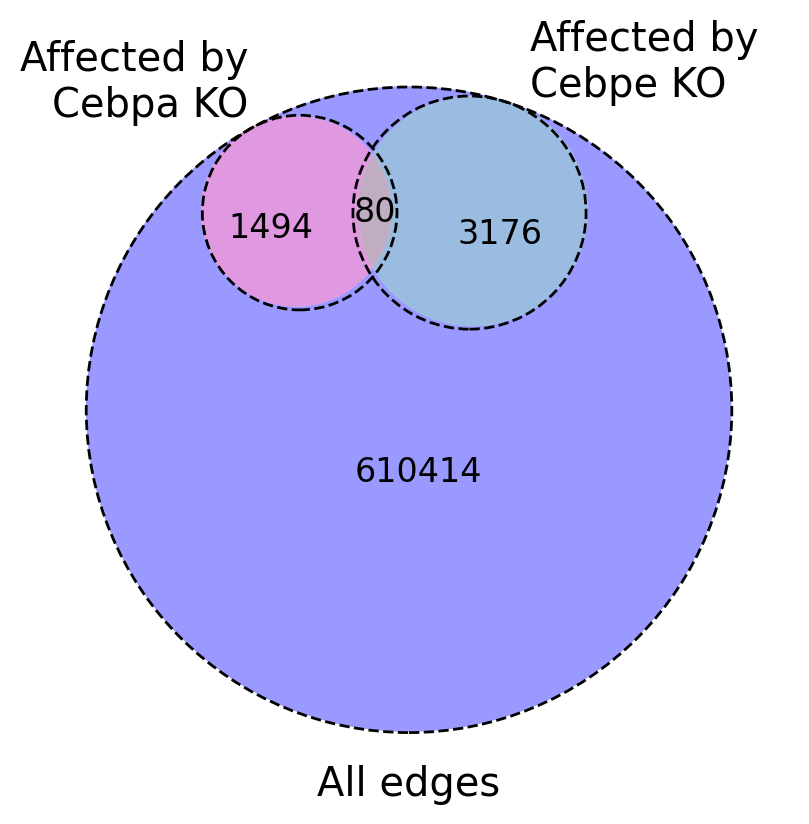

In [39]:
plt.figure(figsize=(5,5))
v = venn3(subsets=(0, 0, 0, 610414, 1494, 3176, 80), 
          set_labels = ('Affected by\nCebpa KO', 'Affected by\nCebpe KO', 'All edges'), 
          layout_algorithm=DefaultLayoutAlgorithm(fixed_subset_sizes=(0,0,0,20, 2, 3, 0.2)))

c = venn3_circles(subsets=(0, 0, 0, 610414, 1494, 3176, 80), linestyle='dashed', 
                  layout_algorithm=DefaultLayoutAlgorithm(fixed_subset_sizes=(0,0,0,20, 2, 3, 0.3)))
c[0].set_lw(1.0)
c[1].set_lw(1.0)
c[2].set_lw(1.0)
plt.show()

## Plot some statistics about learnt weights

In [33]:
edge_stats_df.columns

Index(['edge', 'mean_obs', 'std_obs', 'mean_cebpa', 'std_cebpa', 'mean_cebpe',
       'std_cebpe', 'obs_tstat', 'obs_pvalue', 'cebpa_tstat', 'cebpa_pvalue',
       'cebpe_tstat', 'cebpe_pvalue', 'edge_name', 'gene_1', 'gene_2',
       'mean_diff_cebpa_vs_obs', 'mean_diff_cebpe_vs_obs',
       'cebpa_vs_obs_uncertainty', 'cebpe_vs_obs_uncertainty',
       'Welch_test_cebpa_vs_obs_t_stat', 'Welch_test_cebpe_vs_obs_t_stat',
       'abs_mean_diff_cebpa_vs_obs', 'abs_mean_diff_cebpe_vs_obs',
       'abs_mean_diff_combined', 'uncertainty_combined',
       'abs_Welch_test_cebpa_vs_obs_t_stat',
       'abs_Welch_test_cebpe_vs_obs_t_stat', 'abs_mean_obs', 'abs_mean_cebpa',
       'abs_mean_cebpe'],
      dtype='object')

In [34]:
1/len(edge_stats_df)

1.6255827714235552e-06

In [35]:
len(edge_stats_df) / 4000**2

0.03844775

In [36]:
(edge_stats_df["obs_pvalue"] < 1/len(edge_stats_df)).sum() / 4000**2

0.0076719375

In [37]:
(edge_stats_df["cebpa_pvalue"] < 1/len(edge_stats_df)).sum() / 4000**2

0.006920375

In [38]:
(edge_stats_df["cebpe_pvalue"] < 1/len(edge_stats_df)).sum() / 4000**2

0.008253625

In [39]:
(edge_stats_df["obs_pvalue"] < 1/len(edge_stats_df)).sum() / len(edge_stats_df)

0.19954191077501285

In [40]:
(edge_stats_df["cebpa_pvalue"] < 1/len(edge_stats_df)).sum() / len(edge_stats_df)

0.1799942779486446

In [41]:
(edge_stats_df["cebpe_pvalue"] < 1/len(edge_stats_df)).sum() / len(edge_stats_df)

0.21467120962865188

Edges affected by KOs

In [42]:
len([v for v in list(cebpa_ko_pvalues_dict.values()) if v < 1/len(cebpa_ko_pvalues_dict)]) / 4000**2

9.8375e-05

In [43]:
len([v for v in list(cebpa_ko_pvalues_dict.values()) if v < 1/len(cebpa_ko_pvalues_dict)]) / len(cebpa_ko_pvalues_dict)

0.0025586672822206762

In [44]:
len([v for v in list(cebpe_ko_pvalues_dict.values()) if v < 1/len(cebpe_ko_pvalues_dict)]) / 4000**2

0.0002035

In [45]:
len([v for v in list(cebpe_ko_pvalues_dict.values()) if v < 1/len(cebpe_ko_pvalues_dict)]) / len(cebpe_ko_pvalues_dict)

0.005292897503755096

In [46]:
len([v for k, v in list(cebpe_ko_pvalues_dict.items()) if v < 1/len(cebpe_ko_pvalues_dict) and cebpa_ko_pvalues_dict[k] <  1/len(cebpa_ko_pvalues_dict)]) / 4000**2

5e-06

In [47]:
len([v for k, v in list(cebpe_ko_pvalues_dict.items()) if v < 1/len(cebpe_ko_pvalues_dict) and cebpa_ko_pvalues_dict[k] <  1/len(cebpa_ko_pvalues_dict)]) / len(cebpa_ko_pvalues_dict)

0.00013004662171388443

Change of sign

In [64]:
edge_stats_df.apply(lambda x: (x["mean_obs"]> 0. != x["mean_cebpa"] > 0.)
                                and cebpa_ko_pvalues_dict[x['edge']] < 1/len(edge_stats_df), axis=1).sum() / 4000**2

1.1875e-06

In [65]:
edge_stats_df.apply(lambda x: (x["mean_obs"]> 0. != x["mean_cebpa"] > 0.)
                                and cebpa_ko_pvalues_dict[x['edge']] < 1/len(edge_stats_df), axis=1).sum() / len(edge_stats_df)

3.088607265704755e-05

In [66]:
edge_stats_df.apply(lambda x: (x["mean_obs"]> 0. != x["mean_cebpe"] > 0.)
                                and cebpe_ko_pvalues_dict[x['edge']] < 1/len(edge_stats_df), axis=1).sum() / 4000**2

2.625e-06

In [67]:
edge_stats_df.apply(lambda x: (x["mean_obs"]> 0. != x["mean_cebpe"] > 0.)
                                and cebpe_ko_pvalues_dict[x['edge']] < 1/len(edge_stats_df), axis=1).sum() / len(edge_stats_df)

6.827447639978932e-05

In [ ]:
edge_stats_df.apply(lambda x: (x["mean_obs"]> 0. != x["mean_cebpe"] > 0.)
                                and x["obs_pvalue"] < 1/len(edge_stats_df)
                                and x["cebpe_pvalue"] < 1/len(edge_stats_df), axis=1).sum() / 4000**2

In [86]:
((edge_stats_df["mean_obs"] > 0.) != (edge_stats_df["mean_cebpa"] > 0.)).sum() / 4000**2

0.0013335625

In [87]:
((edge_stats_df["mean_obs"] > 0.) != (edge_stats_df["mean_cebpa"] > 0.)).sum() / len(edge_stats_df)

0.0346850595938644

In [88]:
((edge_stats_df["mean_obs"] > 0.) != (edge_stats_df["mean_cebpe"] > 0.)).sum() / 4000**2

0.0015336875

In [89]:
((edge_stats_df["mean_obs"] > 0.) != (edge_stats_df["mean_cebpe"] > 0.)).sum() / len(edge_stats_df)

0.039890175627962626

## Plot affected subgraph

In [40]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

In [41]:
subgraph_nodes = genes_most_affected_edges_combined_diff_and_uncert + ["Cebpa", "Cebpe"]

In [42]:
graph_edges = mycellpop["gene", "regulates", "gene"].edges.numpy().tolist()

In [43]:
g = nx.DiGraph()
g.add_nodes_from(range(4000))
g.add_edges_from(graph_edges)
nx.set_node_attributes(g, {i: mycellpop["gene"].name[i] for i in range(4000)}, name="name")

In [44]:
g.number_of_edges()

615164

In [45]:
len(mycellpop["gene"].name)

4000

In [46]:
sub_g = g.subgraph([i for i, n in enumerate(mycellpop["gene"].name) if n in subgraph_nodes]).copy()

In [47]:
sub_g.number_of_nodes()

35

In [48]:
sub_g.number_of_edges()

512

In [49]:
sub_g_edges = list(sub_g.edges().keys())

for e in sub_g_edges:
    e_stats = edge_stats_df[edge_stats_df.edge == e]

    if e_stats["obs_pvalue"].item() < 1/g.number_of_edges() \
        or e_stats["cebpa_pvalue"].item() < 1/g.number_of_edges() \
        or e_stats["cebpe_pvalue"].item() < 1/g.number_of_edges():

        sub_g.edges[e[0], e[1]]["mean_obs"] = e_stats["mean_obs"].item()
        sub_g.edges[e[0], e[1]]["mean_cebpa"] = e_stats["mean_cebpa"].item()
        sub_g.edges[e[0], e[1]]["mean_cebpe"] = e_stats["mean_cebpe"].item()

        sub_g.edges[e[0], e[1]]["std_obs"] = e_stats["std_obs"].item()
        sub_g.edges[e[0], e[1]]["std_cebpa"] = e_stats["std_cebpa"].item()
        sub_g.edges[e[0], e[1]]["std_cebpe"] = e_stats["std_cebpe"].item()
    else:
        # if the edge is never significantly different from zero, we remove it
        sub_g.remove_edge(e[0], e[1])


In [50]:
sub_g.number_of_edges()

47

In [51]:
sub_g = sub_g.subgraph(max(nx.connected_components(sub_g.to_undirected()), key=len)).copy()

In [52]:
pos=nx.spring_layout(sub_g, 
                     k=2., 
                     seed=1, 
                     weight=None,  # "mean_obs",
                     iterations=100,
                     )

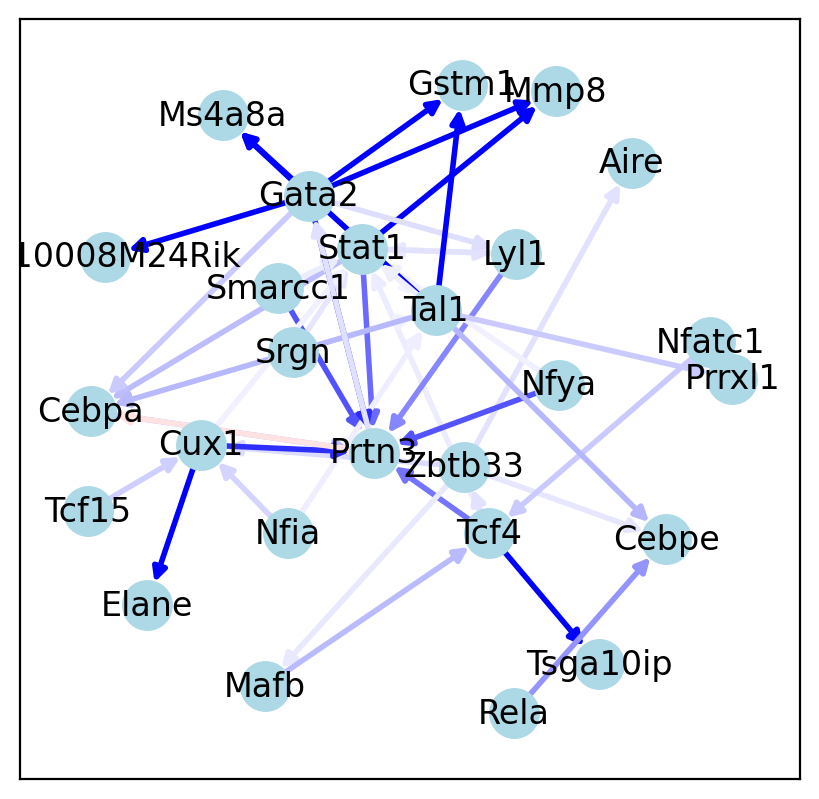

In [53]:
plt.rcParams["figure.figsize"] = (5, 5)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'mean_obs').values()),
        edge_cmap= plt.get_cmap('bwr'),  # plt.cm.plasma,
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=-.5, edge_vmax=.5,
        width=2)
# plt.title("Observational")
plt.show()

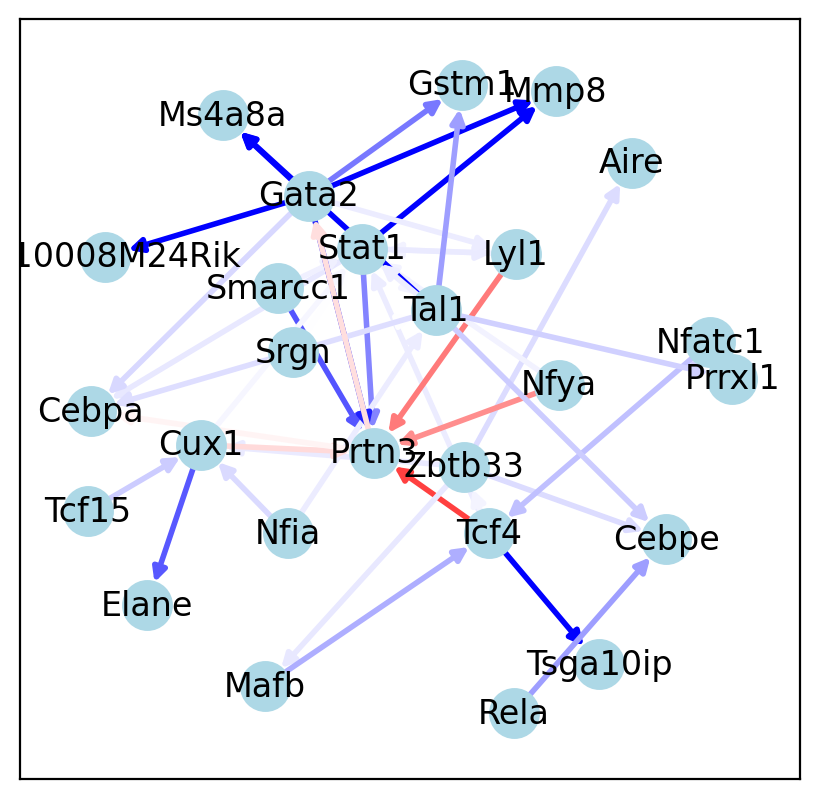

In [54]:
plt.rcParams["figure.figsize"] = (5, 5)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'mean_cebpa').values()),
        edge_cmap= plt.get_cmap('bwr'),  # plt.cm.plasma,
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=-.5, edge_vmax=.5,
        width=2)
# plt.title("Cebpa KO")
plt.show()

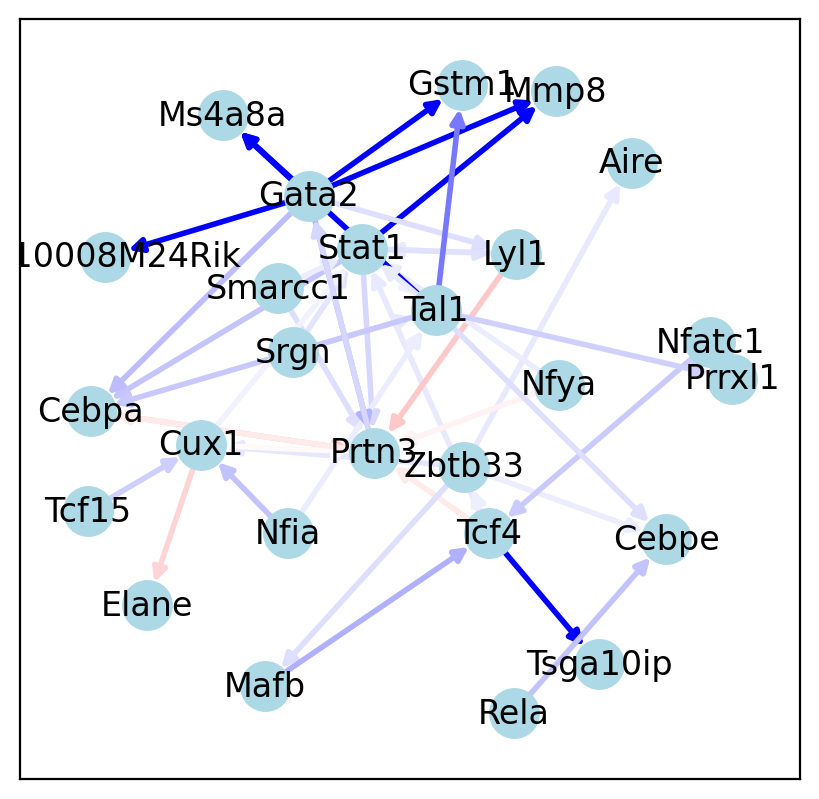

In [55]:
plt.rcParams["figure.figsize"] = (5, 5)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'mean_cebpe').values()),
        edge_cmap= plt.get_cmap('bwr'),  # plt.cm.plasma,
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=-.5, edge_vmax=.5,
        width=2)
# plt.title("Cebpe KO")
plt.show()

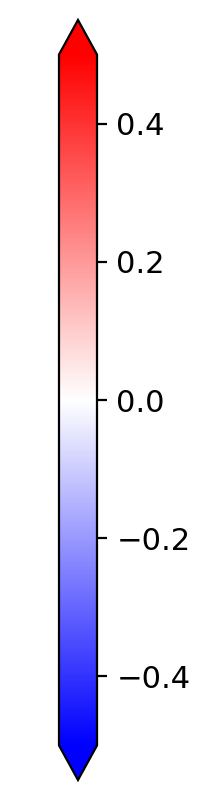

In [56]:
fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

norm = mpl.colors.Normalize(vmin=-.5, vmax=.5)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, 
                                  cmap='bwr'
                                  # mpl.colors.Colormap("jets"),  # 'Blues'
                                 ),
            ax=ax, pad=.05, extend='both', fraction=fraction, orientation="vertical")

ax.axis('off')
plt.show()

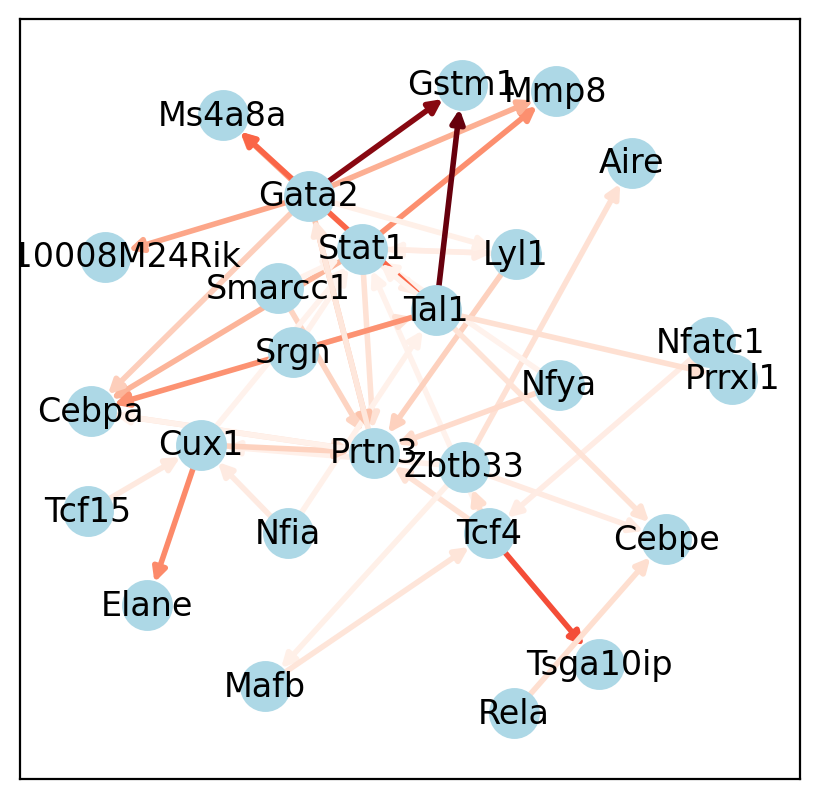

In [57]:
plt.rcParams["figure.figsize"] = (5, 5)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'std_obs').values()),
        edge_cmap= plt.get_cmap('Reds'),
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=0., edge_vmax=.5,
        width=2)
# plt.title("Observational (uncertainty)")
plt.show()

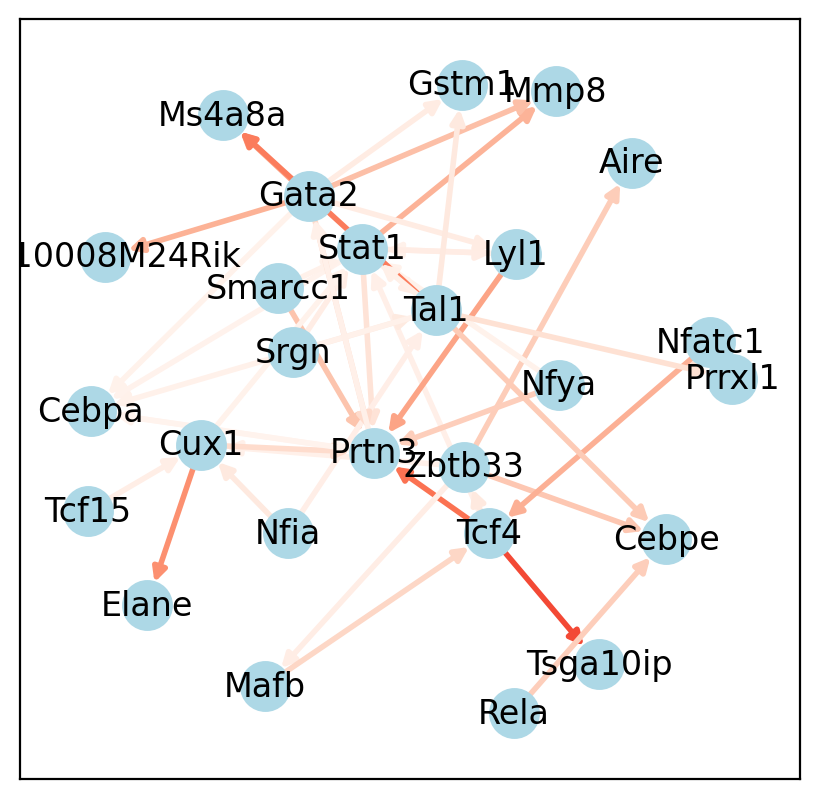

In [58]:
plt.rcParams["figure.figsize"] = (5, 5)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'std_cebpa').values()),
        edge_cmap= plt.get_cmap('Reds'),  # plt.cm.plasma,
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=0., edge_vmax=.5,
        width=2)
# plt.title("Cebpa KO (uncertainty)")
plt.show()

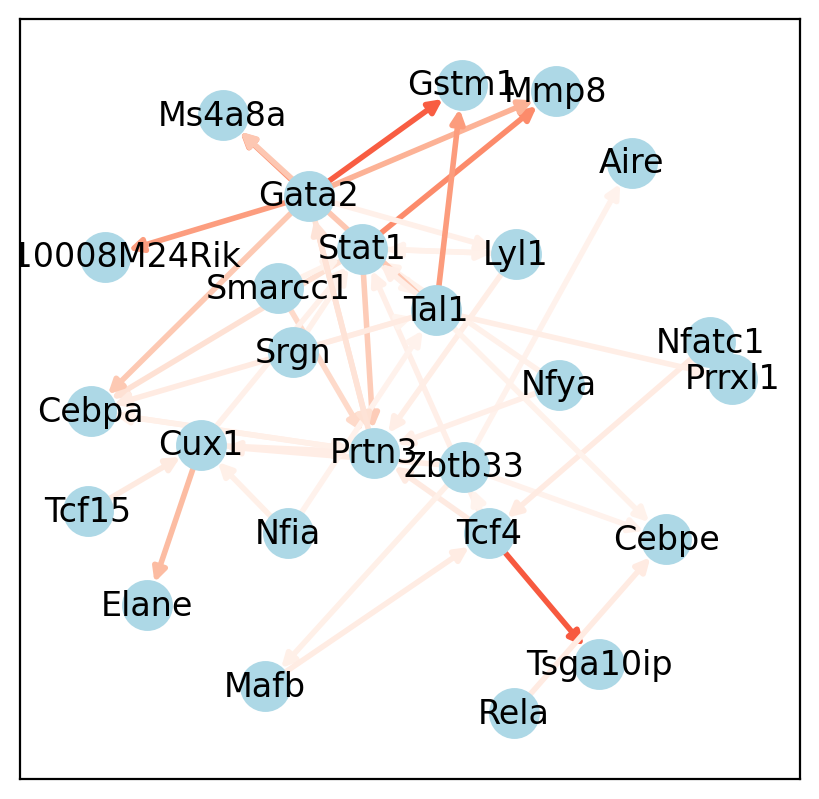

In [59]:
plt.rcParams["figure.figsize"] = (5, 5)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'std_cebpe').values()),
        edge_cmap= plt.get_cmap('Reds'),  # plt.cm.plasma,
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=0., edge_vmax=.5,
        width=2)
# plt.title("Cebpe KO (uncertainty)")
plt.show()

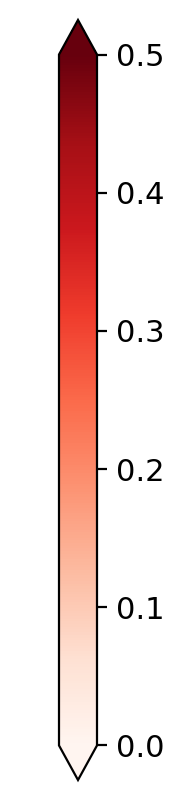

In [60]:
fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

norm = mpl.colors.Normalize(vmin=0., vmax=.5)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, 
                                  cmap='Reds'
                                  # mpl.colors.Colormap("jets"),  # 'Blues'
                                 ),
            ax=ax, pad=.05, extend='both', fraction=fraction, orientation="vertical")

ax.axis('off')
plt.show()

## Edge scatter plot

In [61]:
# We do not visualize KO edges
edge_stats_df_filtered = edge_stats_df[edge_stats_df["gene_1"].apply(lambda x: x not in ["Cebpa", "Cebpe"])]

In [62]:
def label_point(x, y, point_size, val, ax):
    a = pd.concat({'x': x, 'y': y, 'size': point_size, 'val': val}, axis=1)
    prev_annotations = []
    for i, point in a.iterrows():
        if abs(point['x'])> 0.4 or abs(point['y']) > 0.4 or point['size'] > 0.2:
            # We make sure there is not overlap with previously annotated points
            no_overlap = True
            for x,y in prev_annotations:
                if (np.abs(x - point['x']) < .3 and np.abs(y - point['y']) < 0.05):
                    no_overlap = False
            # We handle differently points that are too close to the axis limit
            if point['x'] < -0.75:
                no_overlap = False
                prev_annotations.append((point['x'], point['y']))
                ax.text(point['x'] - 0.08, point['y'] -0.05, str(point['val']))
            if no_overlap:
                # Annotate
                prev_annotations.append((point['x'], point['y']))
                ax.text(point['x']- len(str(point['val']))/ 100., point['y']+.025, str(point['val']))

In [63]:
keeping_proba = edge_stats_df_filtered.apply(lambda x: min(1, x["abs_mean_diff_cebpa_vs_obs"] + x["abs_mean_diff_cebpe_vs_obs"]), 
                                             axis=1)

In [64]:
edge_stats_df_filtered = edge_stats_df_filtered[np.random.binomial(n=1, p= list(keeping_proba)).astype(bool)]

In [65]:
edge_stats_df_filtered.columns

Index(['edge', 'mean_obs', 'std_obs', 'mean_cebpa', 'std_cebpa', 'mean_cebpe',
       'std_cebpe', 'obs_tstat', 'obs_pvalue', 'cebpa_tstat', 'cebpa_pvalue',
       'cebpe_tstat', 'cebpe_pvalue', 'edge_name', 'gene_1', 'gene_2',
       'mean_diff_cebpa_vs_obs', 'mean_diff_cebpe_vs_obs',
       'cebpa_vs_obs_uncertainty', 'cebpe_vs_obs_uncertainty',
       'Welch_test_cebpa_vs_obs_t_stat', 'Welch_test_cebpe_vs_obs_t_stat',
       'abs_mean_diff_cebpa_vs_obs', 'abs_mean_diff_cebpe_vs_obs',
       'abs_mean_diff_combined', 'uncertainty_combined',
       'abs_Welch_test_cebpa_vs_obs_t_stat',
       'abs_Welch_test_cebpe_vs_obs_t_stat', 'abs_mean_obs', 'abs_mean_cebpa',
       'abs_mean_cebpe'],
      dtype='object')

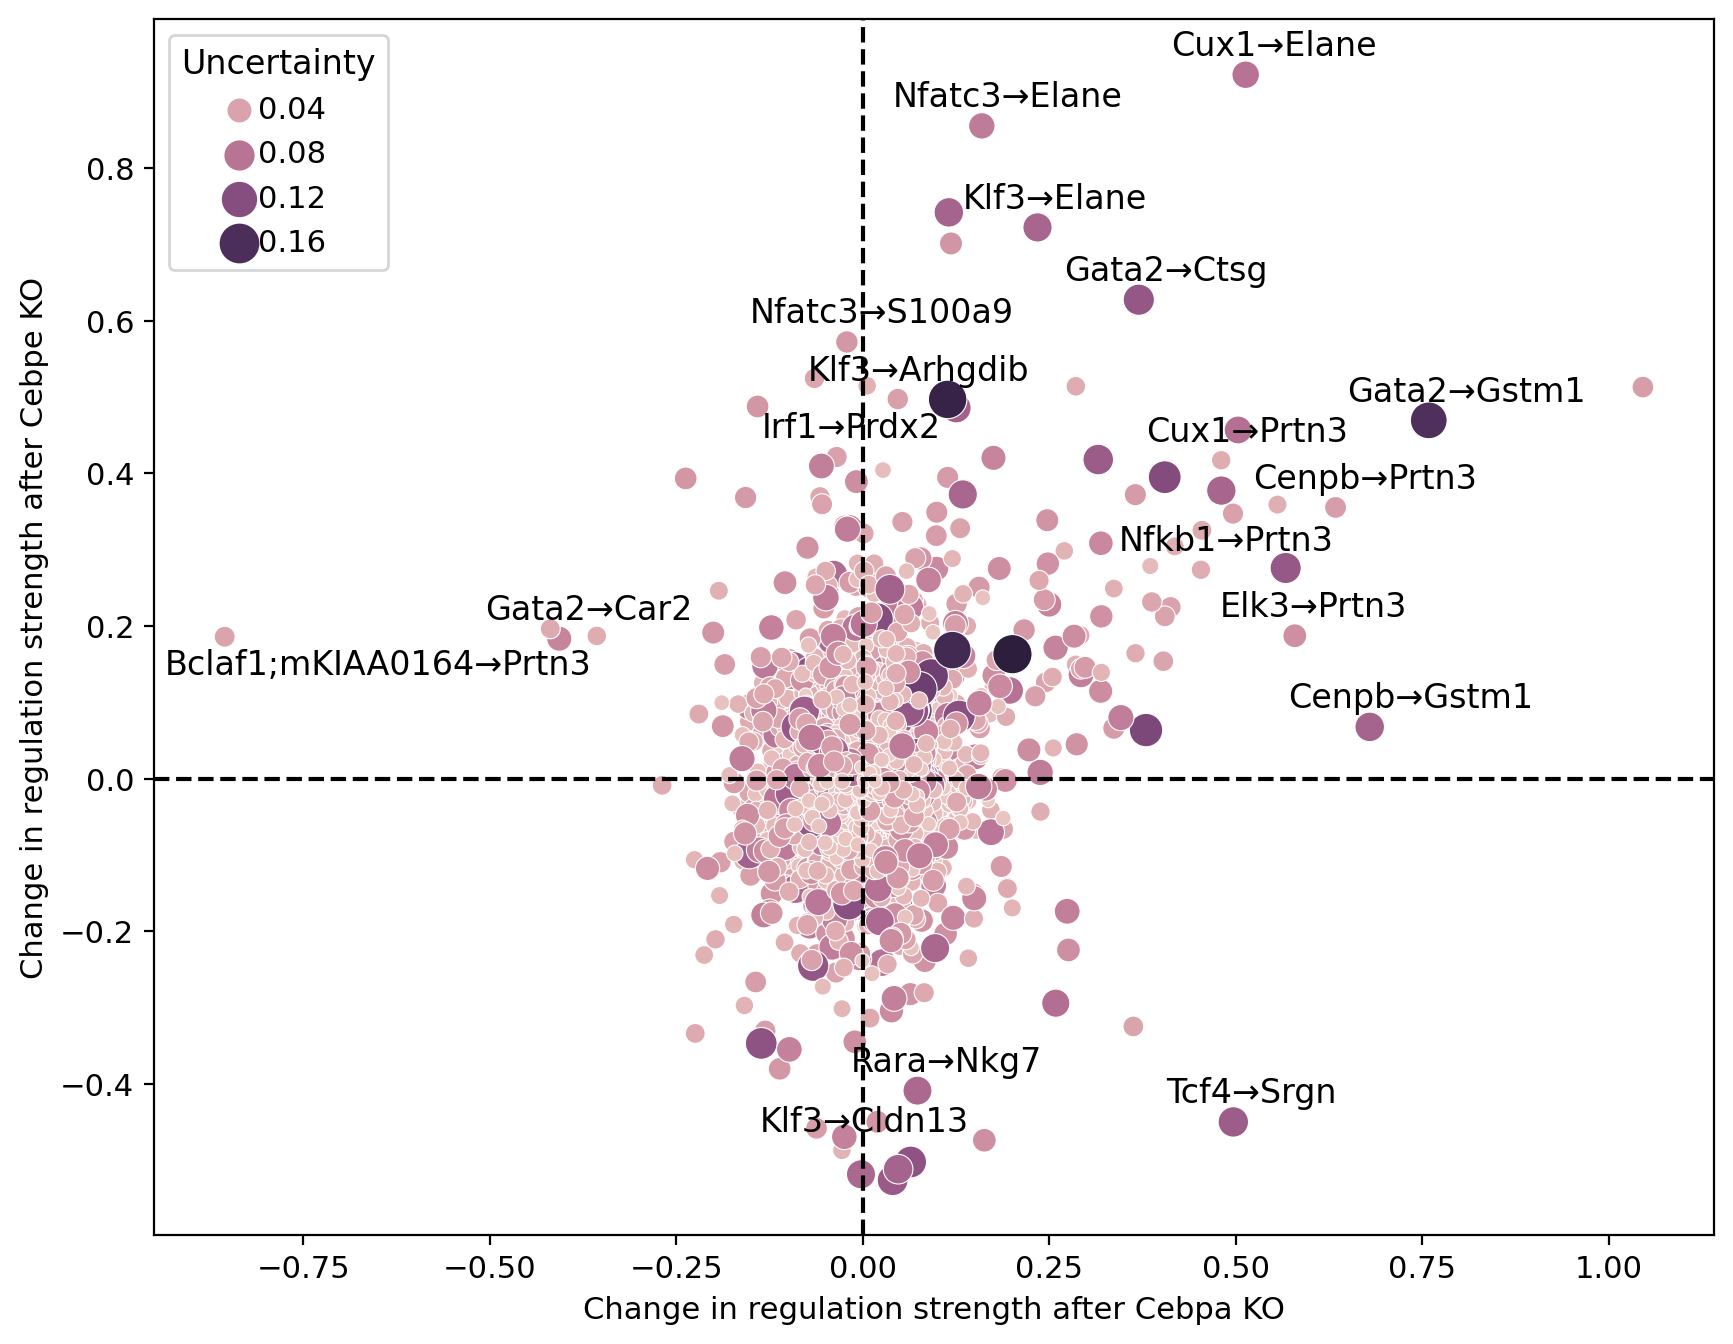

In [66]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(edge_stats_df_filtered, x="mean_diff_cebpa_vs_obs", y="mean_diff_cebpe_vs_obs", 
                     hue="uncertainty_combined", size="uncertainty_combined", sizes=(20, 200))

label_point(edge_stats_df_filtered.mean_diff_cebpa_vs_obs, 
            edge_stats_df_filtered.mean_diff_cebpe_vs_obs, 
            edge_stats_df_filtered.uncertainty_combined, 
            edge_stats_df_filtered.edge_name, plt.gca())

plt.xlabel("Change in regulation strength after Cebpa KO")
plt.ylabel("Change in regulation strength after Cebpe KO")
plt.axhline(y=0., color="black", linestyle="--")
plt.axvline(x=0., color="black", linestyle="--")
# plt.xlim(-1.2, 1.15)
# plt.ylim(-1, 0.6)
plt.legend(title='Uncertainty')
sns.move_legend(ax, "upper left")
plt.show()

## Posterior

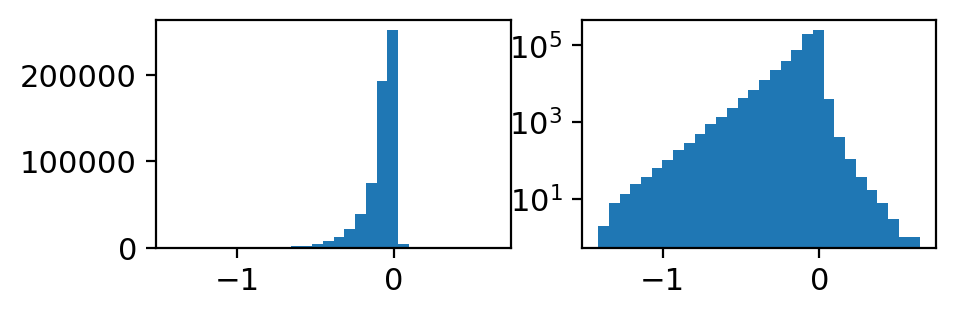

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(5, 1.5))
# fig.suptitle("Posterior means (observational)",  fontsize="small")
axs[0].hist(edge_stats_df["mean_obs"], bins=30)
axs[1].hist(edge_stats_df["mean_obs"], bins=30)
axs[1].set_yscale("log")
plt.show()

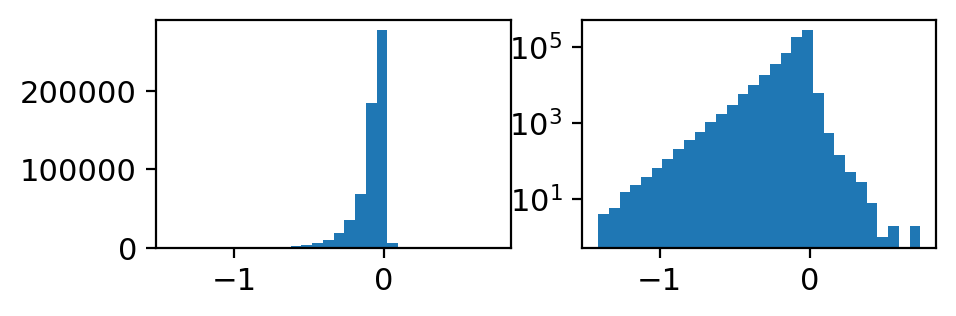

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(5, 1.5))
# fig.suptitle("Posterior means (Cebpa KO)",  fontsize="small")
axs[0].hist(edge_stats_df["mean_cebpa"], bins=30)
axs[1].hist(edge_stats_df["mean_cebpa"], bins=30)
axs[1].set_yscale("log")
plt.show()

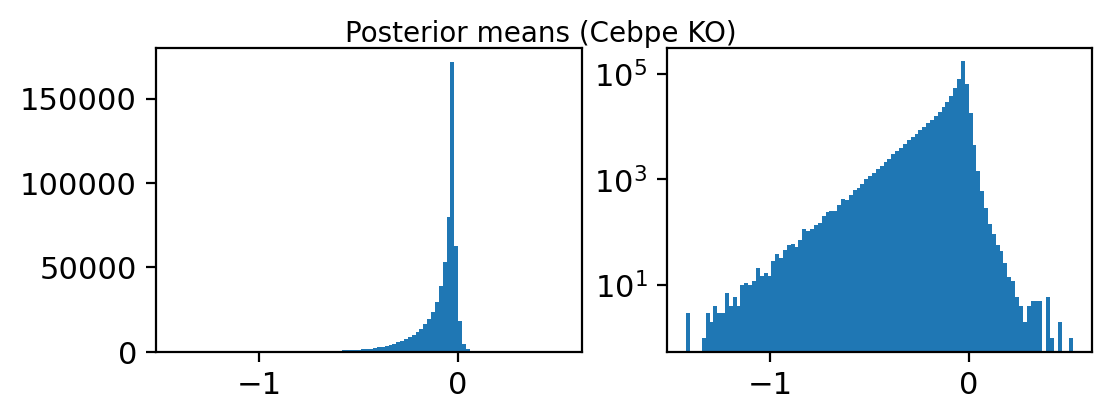

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))
fig.suptitle("Posterior means (Cebpe KO)",  fontsize="small")
axs[0].hist(edge_stats_df["mean_cebpe"], bins=100)
axs[1].hist(edge_stats_df["mean_cebpe"], bins=100)
axs[1].set_yscale("log")
plt.show()

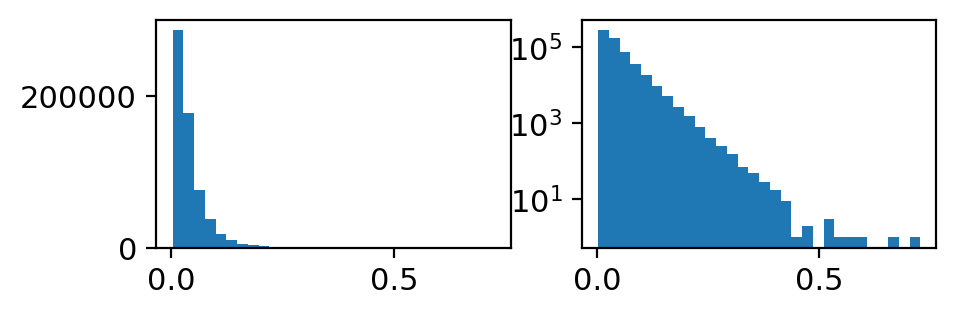

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(5, 1.5))
# fig.suptitle("Posterior std (observational)",  fontsize="small")
axs[0].hist(edge_stats_df["std_obs"], bins=30)
axs[1].hist(edge_stats_df["std_obs"], bins=30)
axs[1].set_yscale("log")
plt.show()

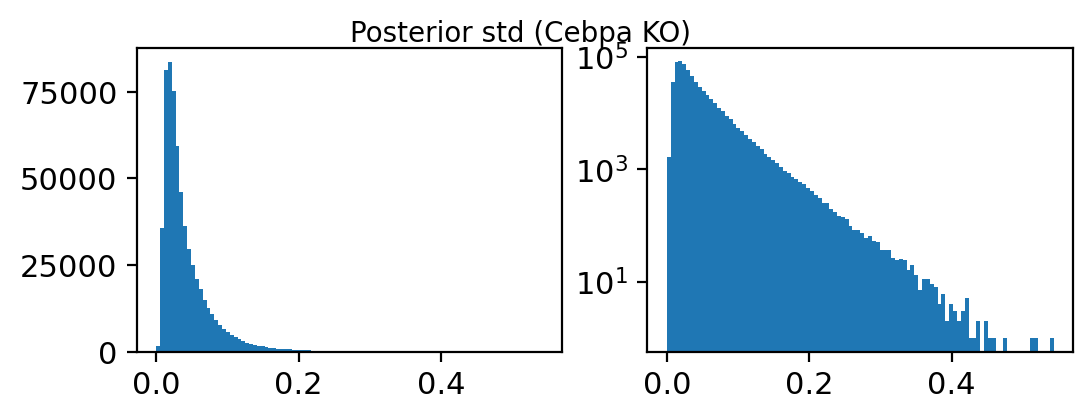

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))
fig.suptitle("Posterior std (Cebpa KO)",  fontsize="small")
axs[0].hist(edge_stats_df["std_cebpa"], bins=100)
axs[1].hist(edge_stats_df["std_cebpa"], bins=100)
axs[1].set_yscale("log")
plt.show()

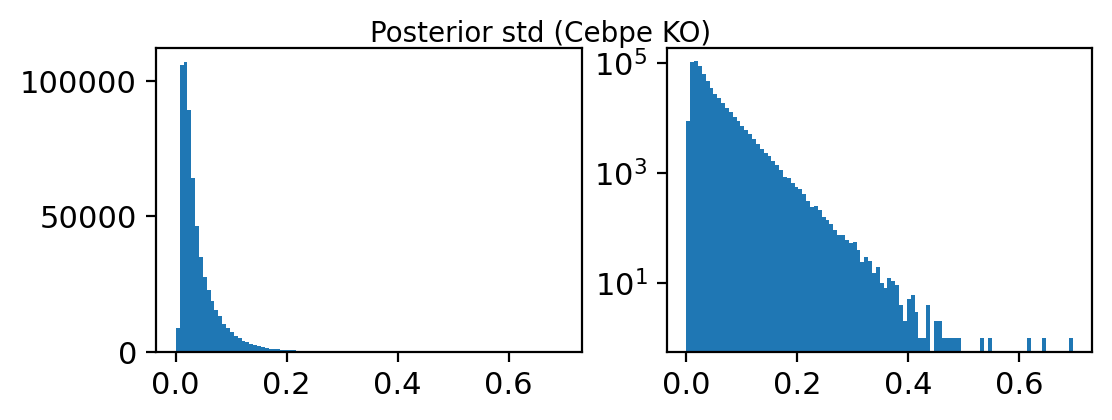

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))
fig.suptitle("Posterior std (Cebpe KO)",  fontsize="small")
axs[0].hist(edge_stats_df["std_cebpe"], bins=100)
axs[1].hist(edge_stats_df["std_cebpe"], bins=100)
axs[1].set_yscale("log")
plt.show()

## Violin plot

In [73]:
# We restrict to edges in subgraph
edge_weight_dict_obs_restr = {k: edge_weight_dict_obs[k] for k in list(sub_g.edges())}
edge_weight_dict_cebpa_restr = {k: edge_weight_dict_cebpa[k] for k in list(sub_g.edges())}
edge_weight_dict_cebpe_restr = {k: edge_weight_dict_cebpe[k] for k in list(sub_g.edges())}

# Create dataframe for the violin plot
obs_df = []
for i in range(10):
   df_i = pd.DataFrame({k: v[i] for k, v in edge_weight_dict_obs_restr.items()}, index=["weight"]).T
   df_i["seed"] = i
   obs_df.append(df_i)

obs_df = pd.concat(obs_df)
obs_df["condition"] = "Observational"

cebpa_ko_df = []
for i in range(10):
   df_i = pd.DataFrame({k: v[i] for k, v in edge_weight_dict_cebpa_restr.items()}, index=["weight"]).T
   df_i["seed"] = i
   cebpa_ko_df.append(df_i)

cebpa_ko_df = pd.concat(cebpa_ko_df)
cebpa_ko_df["condition"] = "Cebpa KO"

cebpe_ko_df = []
for i in range(10):
   df_i = pd.DataFrame({k: v[i] for k, v in edge_weight_dict_cebpe_restr.items()}, index=["weight"]).T
   df_i["seed"] = i
   cebpe_ko_df.append(df_i)

cebpe_ko_df = pd.concat(cebpe_ko_df)
cebpe_ko_df["condition"] = "Cebpe KO"

all_df = pd.concat([obs_df.reset_index(), cebpa_ko_df.reset_index(), cebpe_ko_df.reset_index()])

all_df["edge"] = all_df.apply(lambda x: (gene_names[x["level_0"]], gene_names[x["level_1"]]), axis=1)

all_df.reset_index(inplace=True)

In [74]:
n_sub_g_edges = len(all_df["edge"].unique())
first_half_edges = list(all_df["edge"].unique())[:n_sub_g_edges // 2]
second_half_edges = list(all_df["edge"].unique())[n_sub_g_edges // 2 :]

In [75]:
all_df

index  level_0  level_1    weight  seed      condition              edge
0         0     3457      993 -0.089049     0  Observational     (Tcf15, Cux1)
1         1     3460     3363 -0.030503     0  Observational     (Tcf4, Stat1)
2         2     3460     2788 -0.370078     0  Observational     (Tcf4, Prtn3)
3         3     3460     3669 -0.950959     0  Observational  (Tcf4, Tsga10ip)
4         4     3460     3868 -0.036214     0  Observational    (Tcf4, Zbtb33)
...     ...      ...      ...       ...   ...            ...               ...
1375    455      993     2788  0.066180     9       Cebpe KO     (Cux1, Prtn3)
1376    456      993     3363 -0.045101     9       Cebpe KO     (Cux1, Stat1)
1377    457     2788      804  0.011231     9       Cebpe KO    (Prtn3, Cebpa)
1378    458     2788     1501  0.073472     9       Cebpe KO    (Prtn3, Gata2)
1379    459     2926      805 -0.142880     9       Cebpe KO     (Rela, Cebpe)

[1380 rows x 7 columns]

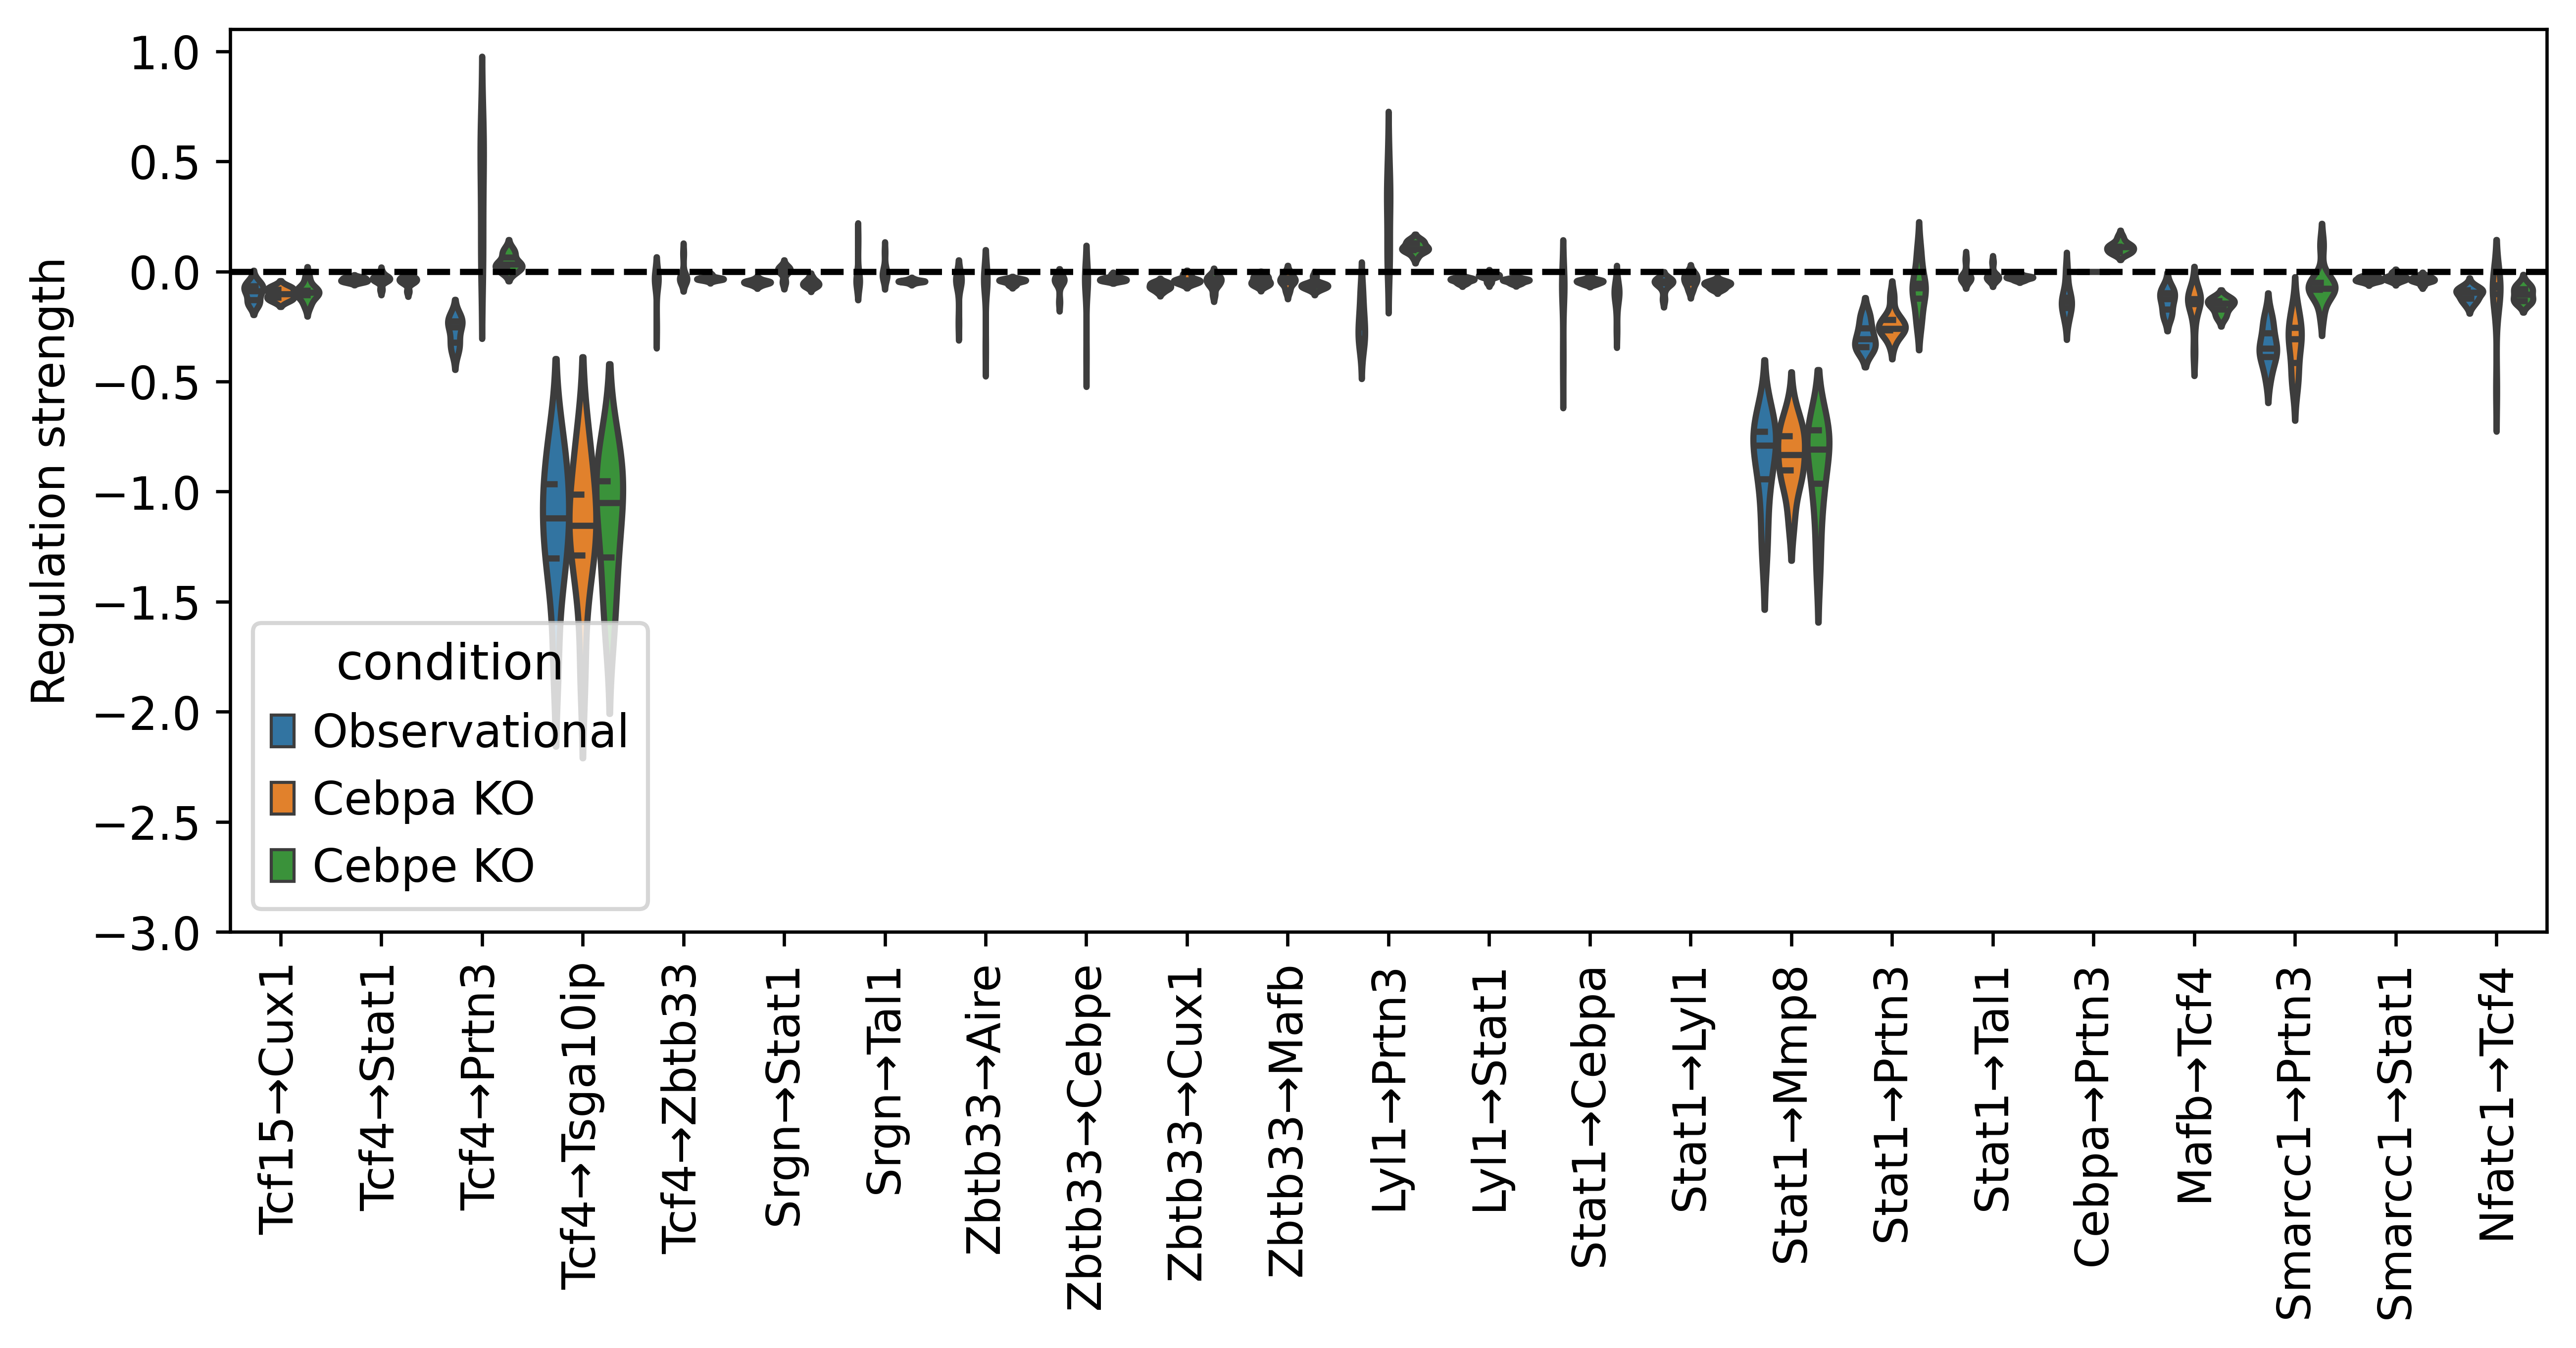

In [76]:
plt.figure(figsize=(10, 4), dpi=300)
this_plot_df = all_df[all_df["edge"].apply(lambda x: x in first_half_edges)]
this_plot_df["edge"] = this_plot_df["edge"].apply(lambda x: x[0] + "→" + x[1])

sns.violinplot(this_plot_df, 
               x="edge", y="weight", hue="condition", split=False, gap=.5, inner="quart")
plt.xticks(rotation=90)
plt.axhline(y=0., color="black", linestyle="--")
plt.ylabel("Regulation strength")
plt.xlabel("")
plt.ylim(-3., 1.1)
plt.show() 

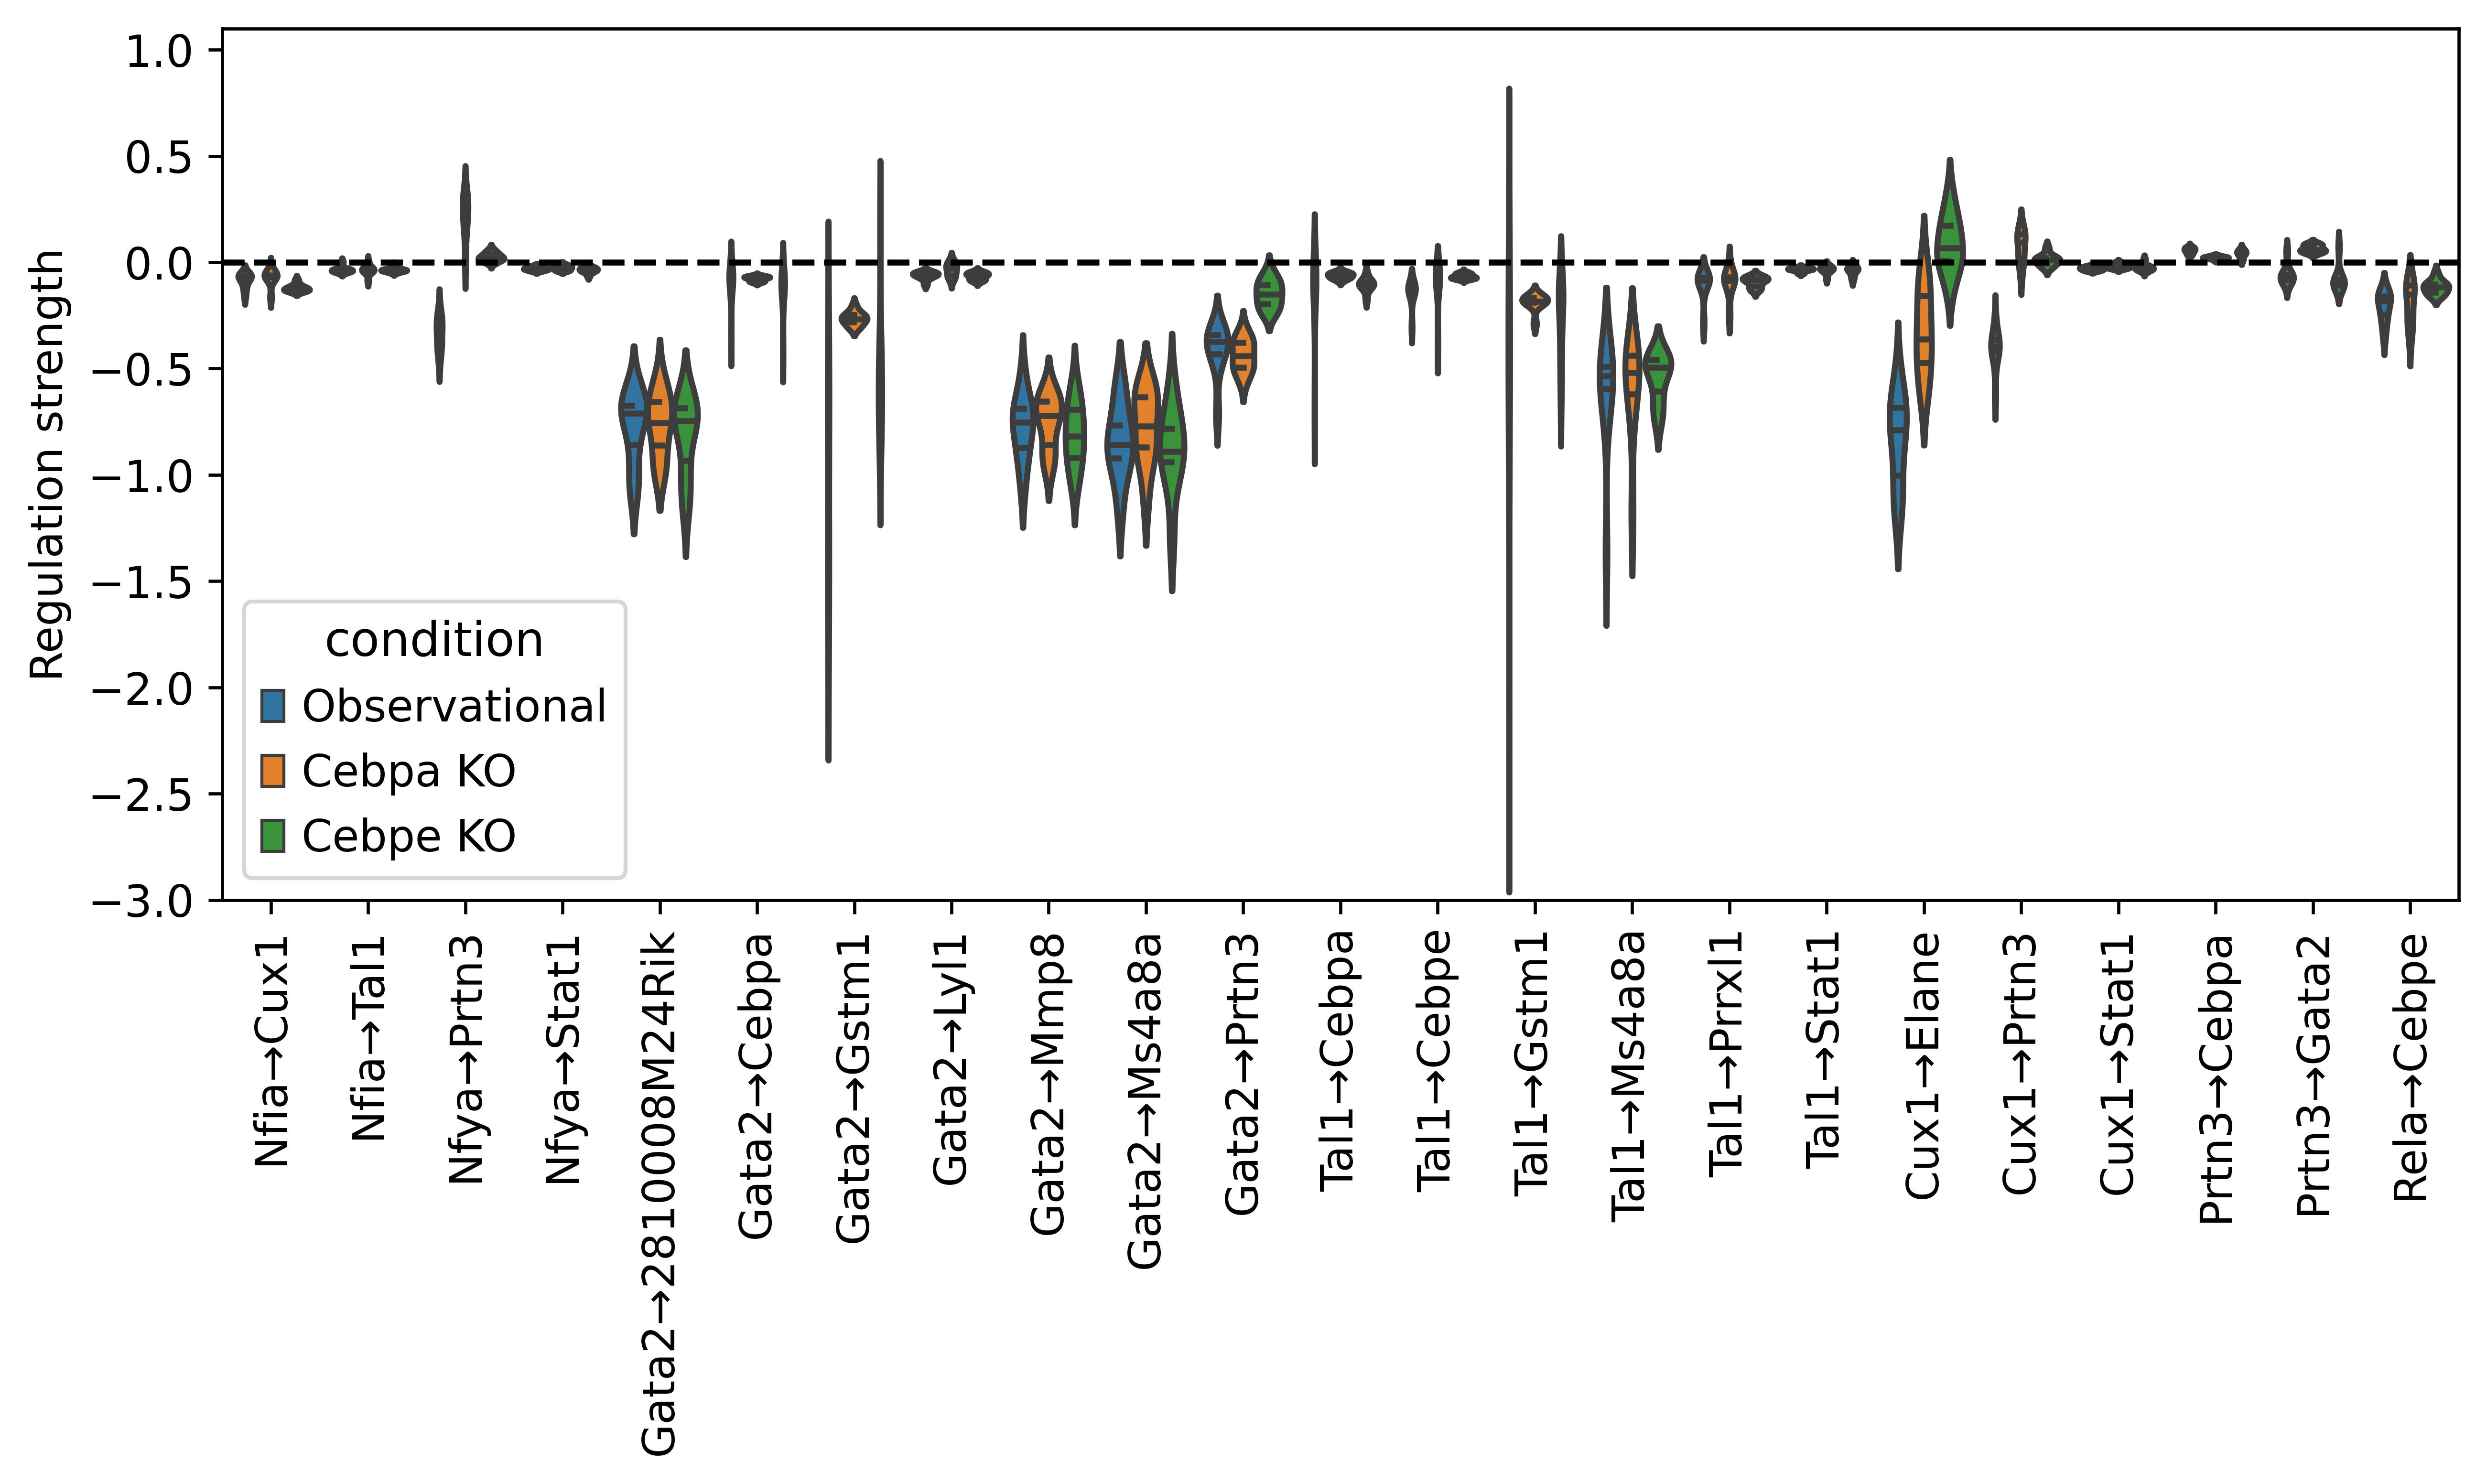

In [78]:
plt.figure(figsize=(10, 4), dpi=300)

this_plot_df = all_df[all_df["edge"].apply(lambda x: x in second_half_edges)]
this_plot_df["edge"] = this_plot_df["edge"].apply(lambda x: x[0] + "→" + x[1])

sns.violinplot(this_plot_df, 
               x="edge", y="weight", hue="condition", split=False, gap=.5, inner="quart")
plt.xticks(rotation=90)
plt.axhline(y=0., color="black", linestyle="--")
plt.ylabel("Regulation strength")
plt.xlabel("")
plt.ylim(-3., 1.1)
plt.show() 

## Retrieve most interesting edges (baselines)

We save the reference of 4000 genes to a txt file

In [111]:
with open('all_genes.txt', 'w') as f:
    for gene in gene_names:
        f.write(f"{gene}\n")

We randomly select 33 genes out of 4000, repeated 5 times

In [112]:
for seed in range(5):
    np.random.seed(seed)
    subsampled_gene_names = [gene_names[i] for i in np.random.choice(4000, 33, replace=False)]

    with open('rand_subsamp_genes_' + str(seed) + '.txt', 'w') as f:
        for gene in subsampled_gene_names:
            f.write(f"{gene}\n")

### Get DE genes

In [113]:
adata_unsorted_cebpa = adata[adata.obs["Batch_desc"].apply(lambda x: x in ["Unsorted myeloid", "Cebpa KO"])]
sc.pp.log1p(adata_unsorted_cebpa)
sc.tl.rank_genes_groups(adata_unsorted_cebpa, 'Batch_desc', method='t-test', key_added = "t-test")

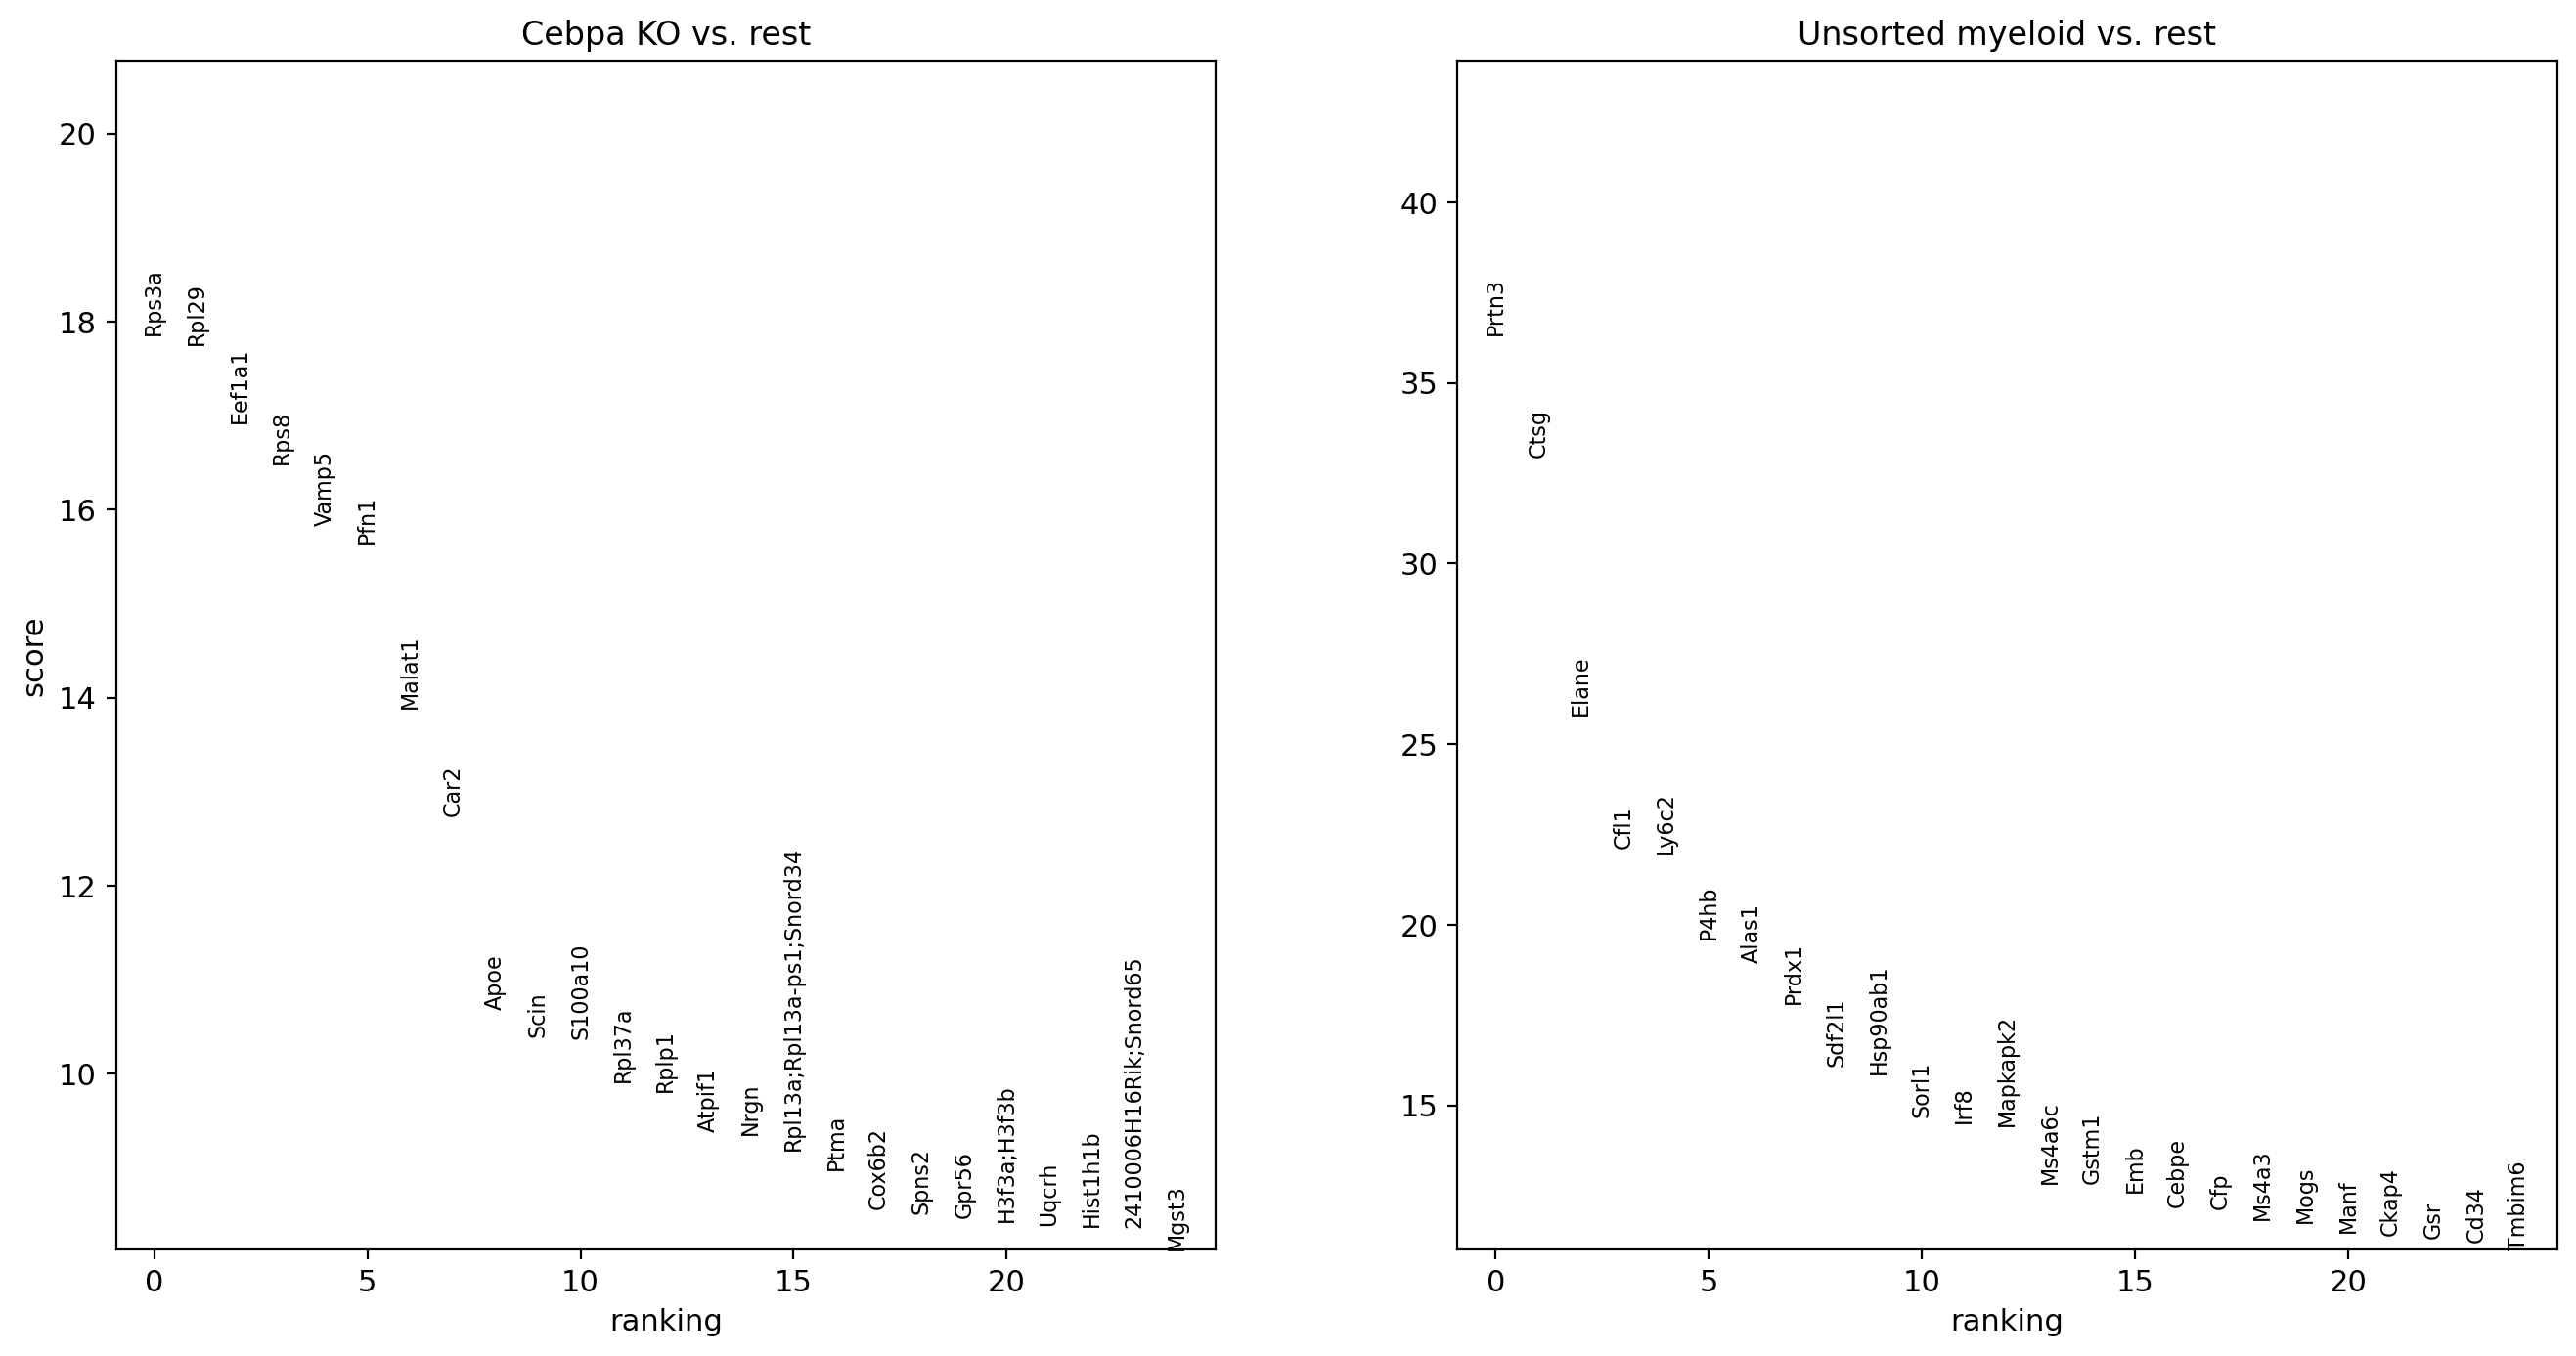

In [114]:
sc.pl.rank_genes_groups(adata_unsorted_cebpa, n_genes=25, sharey=False, key = "t-test")

In [115]:
abs_scores_cebpa_ttests = {adata_unsorted_cebpa.uns["t-test"]['names']['Cebpa KO'][i]: 
                       np.abs(adata_unsorted_cebpa.uns["t-test"]['scores']['Cebpa KO'][i])
                       for i in range(len(adata_unsorted_cebpa.uns["t-test"]['names']['Cebpa KO']))}

# Sort dictionary according to value
abs_scores_cebpa_ttests = {k: v for k, v in sorted(abs_scores_cebpa_ttests.items(), key=lambda item: -item[1])}


In [116]:
# Most affected genes cebpa KO
de_genes_cebpa_ko = list(abs_scores_cebpa_ttests)[:33]
with open('DE_genes_cebpa_ko.txt', 'w') as f:
    for gene in de_genes_cebpa_ko:
        f.write(f"{gene}\n")

In [117]:
adata_unsorted_cebpe = adata[adata.obs["Batch_desc"].apply(lambda x: x in ["Unsorted myeloid", "Cebpe KO"])]
sc.pp.log1p(adata_unsorted_cebpe)
sc.tl.rank_genes_groups(adata_unsorted_cebpe, 'Batch_desc', method='t-test', key_added = "t-test")

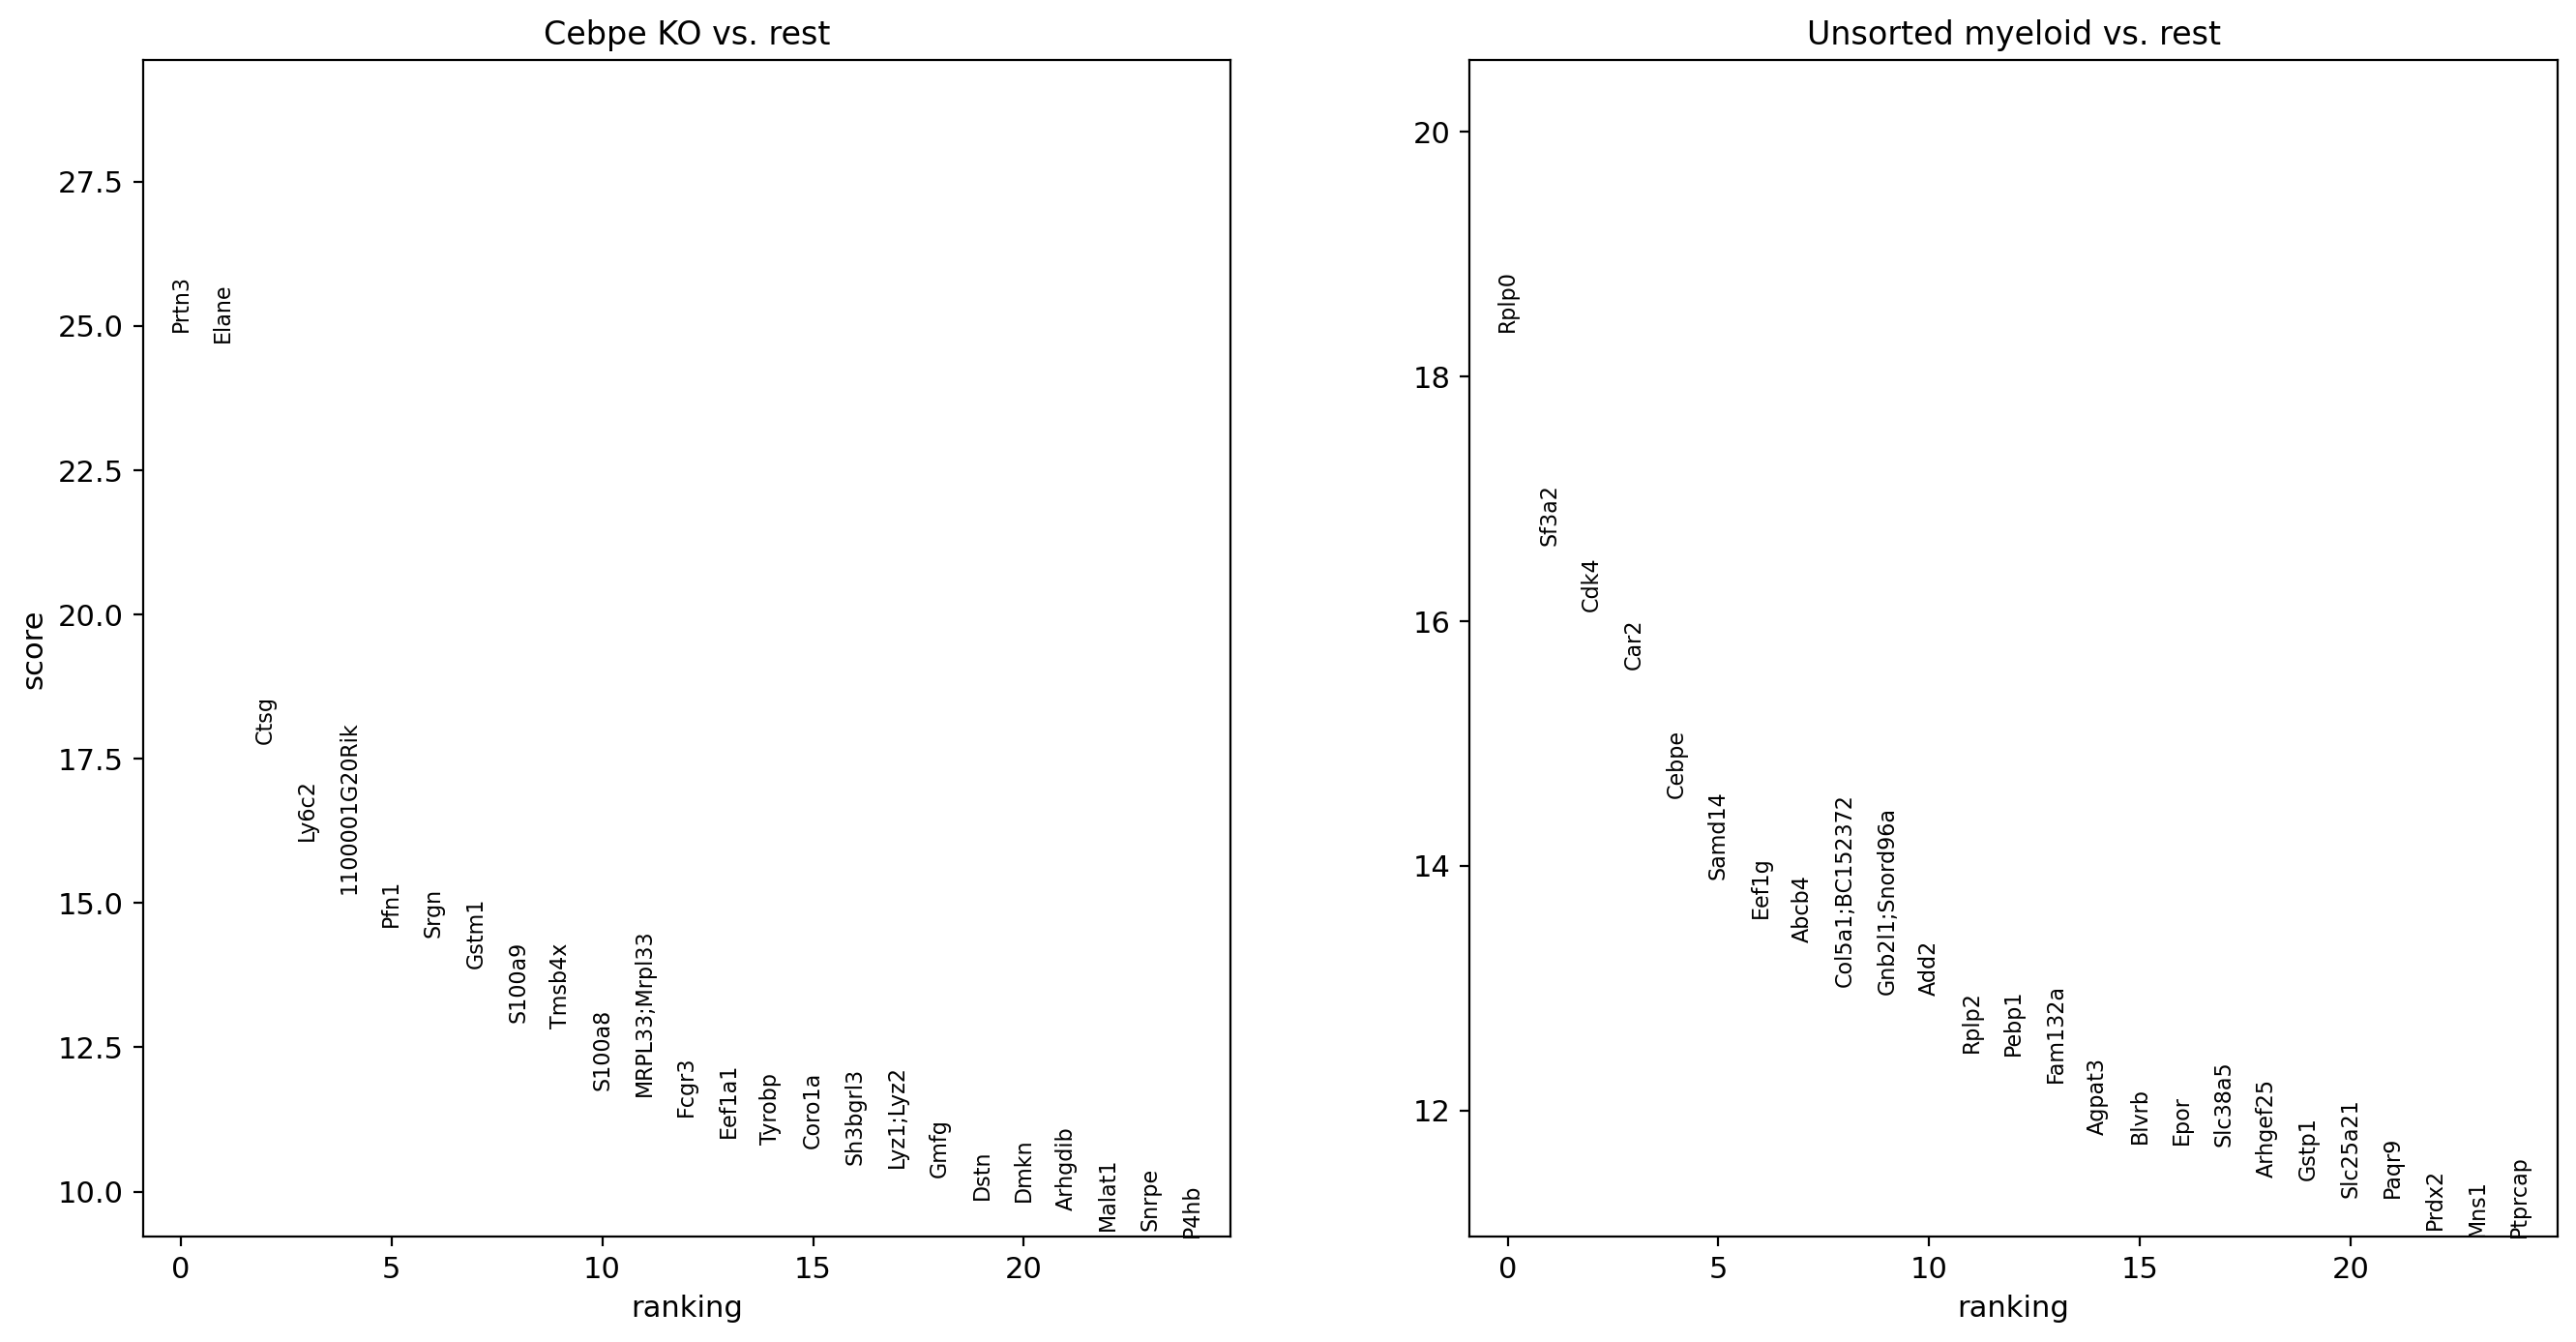

In [118]:
sc.pl.rank_genes_groups(adata_unsorted_cebpe, n_genes=25, sharey=False, key = "t-test")

In [119]:
abs_scores_cebpe_ttests = {adata_unsorted_cebpe.uns["t-test"]['names']['Cebpe KO'][i]: 
                       np.abs(adata_unsorted_cebpe.uns["t-test"]['scores']['Cebpe KO'][i])
                       for i in range(len(adata_unsorted_cebpe.uns["t-test"]['names']['Cebpe KO']))}

# Sort dictionary according to value
abs_scores_cebpe_ttests = {k: v for k, v in sorted(abs_scores_cebpe_ttests.items(), key=lambda item: -item[1])}


In [120]:
# Most affected genes cebpe KO
de_genes_cebpe_ko = list(abs_scores_cebpe_ttests)[:33]
with open('DE_genes_cebpe_ko.txt', 'w') as f:
    for gene in de_genes_cebpe_ko:
        f.write(f"{gene}\n")

Combined list of affected genes

In [121]:
# Combine using the geometric average
geo_avg_scores_ttests_combined = {k: v*abs_scores_cebpe_ttests[k] for k, v in abs_scores_cebpa_ttests.items()}

# Sort dictionary according to value
geo_avg_scores_ttests_combined = {k: v for k, v in sorted(geo_avg_scores_ttests_combined.items(), key=lambda item: -item[1])}

In [122]:
# Most affected genes combined
de_genes_combined = list(geo_avg_scores_ttests_combined)[:33]
with open('DE_genes_combined.txt', 'w') as f:
    for gene in de_genes_combined:
        f.write(f"{gene}\n")